# ANÁLISE DE DADOS - LEAGUE OF LEGENDS RANKED MATCHES
# MODELOS: REGRESSÃO LOGÍSTICA, NAIVE BAYES E ÁRVORE DE DECISÃO
# MÉTRICAS: ROC E AUC COM VALIDAÇÃO CRUZADA

In [35]:
# Importação das bibliotecas
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Pré-processamento
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler

# Modelos solicitados
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

# Modelos de Ensemble para comparação
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier

# Validação e métricas
from sklearn.model_selection import (train_test_split, cross_val_score, 
                                   StratifiedKFold, GridSearchCV)
from sklearn.metrics import (classification_report, confusion_matrix, 
                           roc_auc_score, roc_curve, auc, accuracy_score,
                           f1_score, precision_score, recall_score)

# Configurações de visualização
plt.style.use('ggplot')
sns.set_palette("husl")

## CARREGAMENTO E EXPLORAÇÃO INICIAL DOS DADOS

In [36]:
# Carregar dados
df = pd.read_csv('Base_M43_Pratique_LOL_RANKED_WIN.csv', sep=',')

In [37]:
print(f"Dimensões do dataset: {df.shape}")

Dimensões do dataset: (9879, 40)


In [38]:
print(f"Colunas: {list(df.columns)}")

Colunas: ['gameId', 'blueWins', 'blueWardsPlaced', 'blueWardsDestroyed', 'blueFirstBlood', 'blueKills', 'blueDeaths', 'blueAssists', 'blueEliteMonsters', 'blueDragons', 'blueHeralds', 'blueTowersDestroyed', 'blueTotalGold', 'blueAvgLevel', 'blueTotalExperience', 'blueTotalMinionsKilled', 'blueTotalJungleMinionsKilled', 'blueGoldDiff', 'blueExperienceDiff', 'blueCSPerMin', 'blueGoldPerMin', 'redWardsPlaced', 'redWardsDestroyed', 'redFirstBlood', 'redKills', 'redDeaths', 'redAssists', 'redEliteMonsters', 'redDragons', 'redHeralds', 'redTowersDestroyed', 'redTotalGold', 'redAvgLevel', 'redTotalExperience', 'redTotalMinionsKilled', 'redTotalJungleMinionsKilled', 'redGoldDiff', 'redExperienceDiff', 'redCSPerMin', 'redGoldPerMin']


In [39]:
# Primeiras linhas do dataset
df.head()

,gameId,blueWins,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,...,redTowersDestroyed,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled,redGoldDiff,redExperienceDiff,redCSPerMin,redGoldPerMin
0,4519157822,0,28,2,1,9,6,11,0,0,...,0,16567,6.8,17047,197,55,-643,8,19.7,1656.7
1,4523371949,0,12,1,0,5,5,5,0,0,...,1,17620,6.8,17438,240,52,2908,1173,24.0,1762.0
2,4521474530,0,15,0,0,7,11,4,1,1,...,0,17285,6.8,17254,203,28,1172,1033,20.3,1728.5
3,4524384067,0,43,1,0,4,5,5,1,0,...,0,16478,7.0,17961,235,47,1321,7,23.5,1647.8
4,4436033771,0,75,4,0,6,6,6,0,0,...,0,17404,7.0,18313,225,67,1004,-230,22.5,1740.4


In [40]:
#Informações do dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9879 entries, 0 to 9878
Data columns (total 40 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   gameId                        9879 non-null   int64  
 1   blueWins                      9879 non-null   int64  
 2   blueWardsPlaced               9879 non-null   int64  
 3   blueWardsDestroyed            9879 non-null   int64  
 4   blueFirstBlood                9879 non-null   int64  
 5   blueKills                     9879 non-null   int64  
 6   blueDeaths                    9879 non-null   int64  
 7   blueAssists                   9879 non-null   int64  
 8   blueEliteMonsters             9879 non-null   int64  
 9   blueDragons                   9879 non-null   int64  
 10  blueHeralds                   9879 non-null   int64  
 11  blueTowersDestroyed           9879 non-null   int64  
 12  blueTotalGold                 9879 non-null   int64  
 13  blu

In [41]:
## Estatísticas descritivas
df.describe()

,gameId,blueWins,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,...,redTowersDestroyed,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled,redGoldDiff,redExperienceDiff,redCSPerMin,redGoldPerMin
count,9.879000e+03,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,...,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000
mean,4.500084e+09,0.499038,22.288288,2.824881,0.504808,6.183925,6.137666,6.645106,0.549954,0.361980,...,0.043021,16489.041401,6.925316,17961.730438,217.349226,51.313088,-14.414111,33.620306,21.734923,1648.904140
std,2.757328e+07,0.500024,18.019177,2.174998,0.500002,3.011028,2.933818,4.064520,0.625527,0.480597,...,0.216900,1490.888406,0.305311,1198.583912,21.911668,10.027885,2453.349179,1920.370438,2.191167,149.088841
min,4.295358e+09,0.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,11212.000000,4.800000,10465.000000,107.000000,4.000000,-11467.000000,-8348.000000,10.700000,1121.200000
25%,4.483301e+09,0.000000,14.000000,1.000000,0.000000,4.000000,4.000000,4.000000,0.000000,0.000000,...,0.000000,15427.500000,6.800000,17209.500000,203.000000,44.000000,-1596.000000,-1212.000000,20.300000,1542.750000
50%,4.510920e+09,0.000000,16.000000,3.000000,1.000000,6.000000,6.000000,6.000000,0.000000,0.000000,...,0.000000,16378.000000,7.000000,17974.000000,218.000000,51.000000,-14.000000,28.000000,21.800000,1637.800000
75%,4.521733e+09,1.000000,20.000000,4.000000,1.000000,8.000000,8.000000,9.000000,1.000000,1.000000,...,0.000000,17418.500000,7.200000,18764.500000,233.000000,57.000000,1585.500000,1290.500000,23.300000,1741.850000
max,4.527991e+09,1.000000,250.000000,27.000000,1.000000,22.000000,22.000000,29.000000,2.000000,1.000000,...,2.000000,22732.000000,8.200000,22269.000000,289.000000,92.000000,10830.000000,9333.000000,28.900000,2273.200000


In [42]:
## Valores nulos por coluna
df.isnull().sum()

gameId                          0
blueWins                        0
blueWardsPlaced                 0
blueWardsDestroyed              0
blueFirstBlood                  0
blueKills                       0
blueDeaths                      0
blueAssists                     0
blueEliteMonsters               0
blueDragons                     0
blueHeralds                     0
blueTowersDestroyed             0
blueTotalGold                   0
blueAvgLevel                    0
blueTotalExperience             0
blueTotalMinionsKilled          0
blueTotalJungleMinionsKilled    0
blueGoldDiff                    0
blueExperienceDiff              0
blueCSPerMin                    0
blueGoldPerMin                  0
redWardsPlaced                  0
redWardsDestroyed               0
redFirstBlood                   0
redKills                        0
redDeaths                       0
redAssists                      0
redEliteMonsters                0
redDragons                      0
redHeralds    

Distribuição da Variável Alvo (blueWins):
Classe 0 (Derrota Blue): 4949 (50.10%)
Classe 1 (Vitória Blue): 4930 (49.90%)


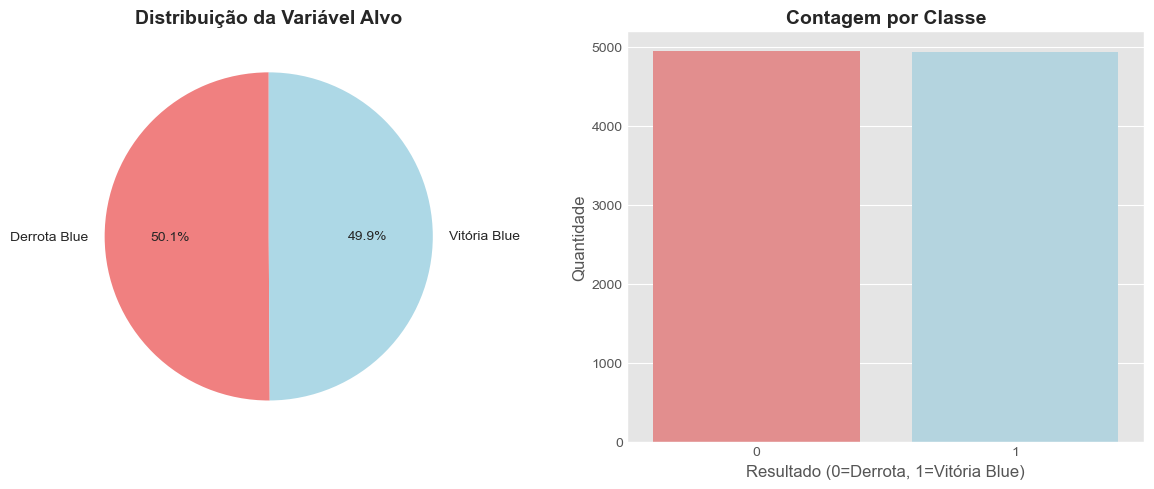

In [43]:
# Distribuição da variável alvo
print(f"Distribuição da Variável Alvo (blueWins):")
target_counts = df['blueWins'].value_counts()
target_percent = df['blueWins'].value_counts(normalize=True) * 100

print(f"Classe 0 (Derrota Blue): {target_counts[0]} ({target_percent[0]:.2f}%)")
print(f"Classe 1 (Vitória Blue): {target_counts[1]} ({target_percent[1]:.2f}%)")

# Visualização da distribuição da variável alvo
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.pie(target_counts.values, labels=['Derrota Blue', 'Vitória Blue'], 
        autopct='%1.1f%%', startangle=90, colors=['lightcoral', 'lightblue'])
plt.title('Distribuição da Variável Alvo', fontsize=14, fontweight='bold')

plt.subplot(1, 2, 2)
sns.countplot(data=df, x='blueWins', palette=['lightcoral', 'lightblue'])
plt.title('Contagem por Classe', fontsize=14, fontweight='bold')
plt.xlabel('Resultado (0=Derrota, 1=Vitória Blue)')
plt.ylabel('Quantidade')

plt.tight_layout()
plt.show()

## VISUALIZAÇÕES EXPLORATÓRIAS

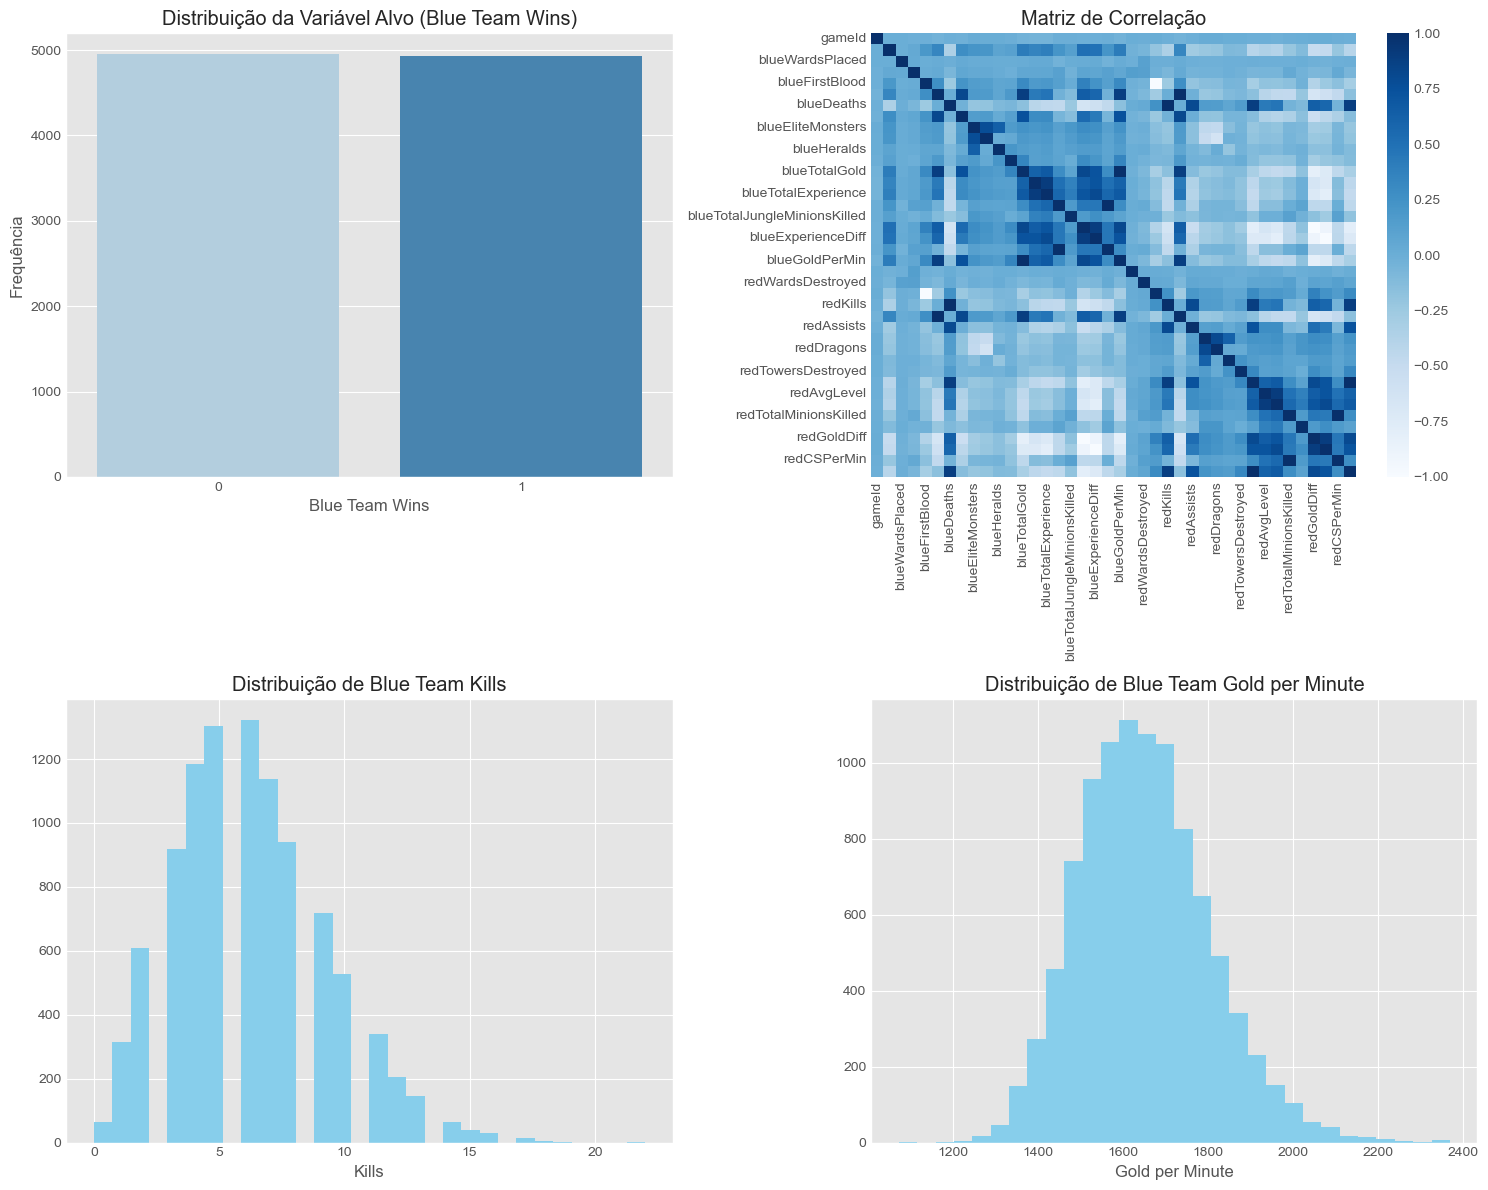

In [44]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Distribuição da variável alvo
sns.countplot(data=df, x='blueWins', ax=axes[0,0], palette='Blues')
axes[0,0].set_title('Distribuição da Variável Alvo (Blue Team Wins)')
axes[0,0].set_xlabel('Blue Team Wins')
axes[0,0].set_ylabel('Frequência')

# Matriz de correlação
corr_matrix = df.select_dtypes(include=[np.number]).corr()
sns.heatmap(corr_matrix, cmap='Blues', center=0, ax=axes[0,1])
axes[0,1].set_title('Matriz de Correlação')

# Distribuição de algumas variáveis importantes
df['blueKills'].hist(bins=30, ax=axes[1,0], color='skyblue')
axes[1,0].set_title('Distribuição de Blue Team Kills')
axes[1,0].set_xlabel('Kills')

df['blueGoldPerMin'].hist(bins=30, ax=axes[1,1], color='skyblue')
axes[1,1].set_title('Distribuição de Blue Team Gold per Minute')
axes[1,1].set_xlabel('Gold per Minute')

plt.tight_layout()
plt.show()

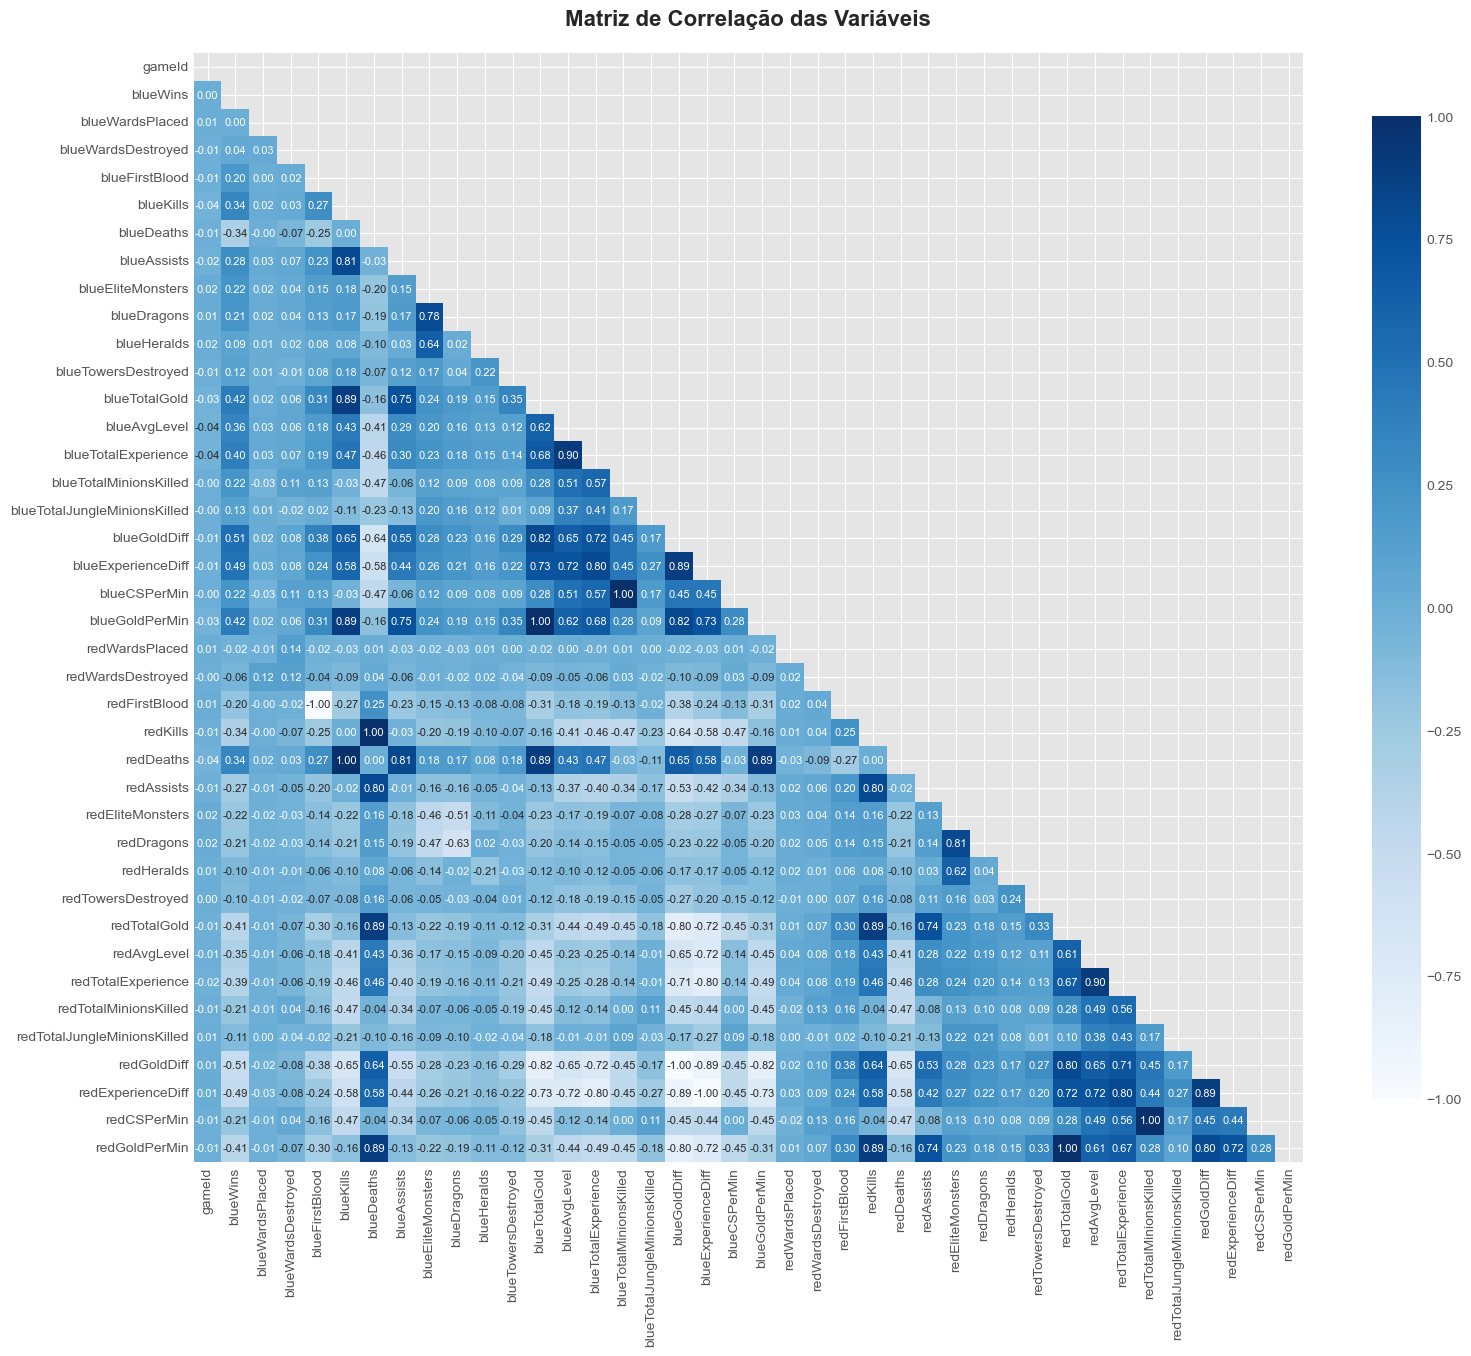

In [45]:
# Matriz de correlação
plt.figure(figsize=(16, 14))
# Cria uma máscara para a metade superior
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, 
            mask=mask, 
            annot=True, 
            cmap='Blues', 
            center=0,
            square=True, 
            fmt='.2f', 
            cbar_kws={"shrink": 0.8},
            annot_kws={'size': 8})
plt.title('Matriz de Correlação das Variáveis', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

In [46]:
# Correlacao absoluta das features com 'blueWins'
target_corr = corr_matrix['blueWins'].abs().sort_values(ascending=False)

# Mostra as top 10 features mais correlacionadas
print(target_corr[1:11])  # [1:] para pular a própria target (blueWins)

redGoldDiff            0.511119
blueGoldDiff           0.511119
redExperienceDiff      0.489558
blueExperienceDiff     0.489558
blueTotalGold          0.417213
blueGoldPerMin         0.417213
redTotalGold           0.411396
redGoldPerMin          0.411396
blueTotalExperience    0.396141
redTotalExperience     0.387588
Name: blueWins, dtype: float64


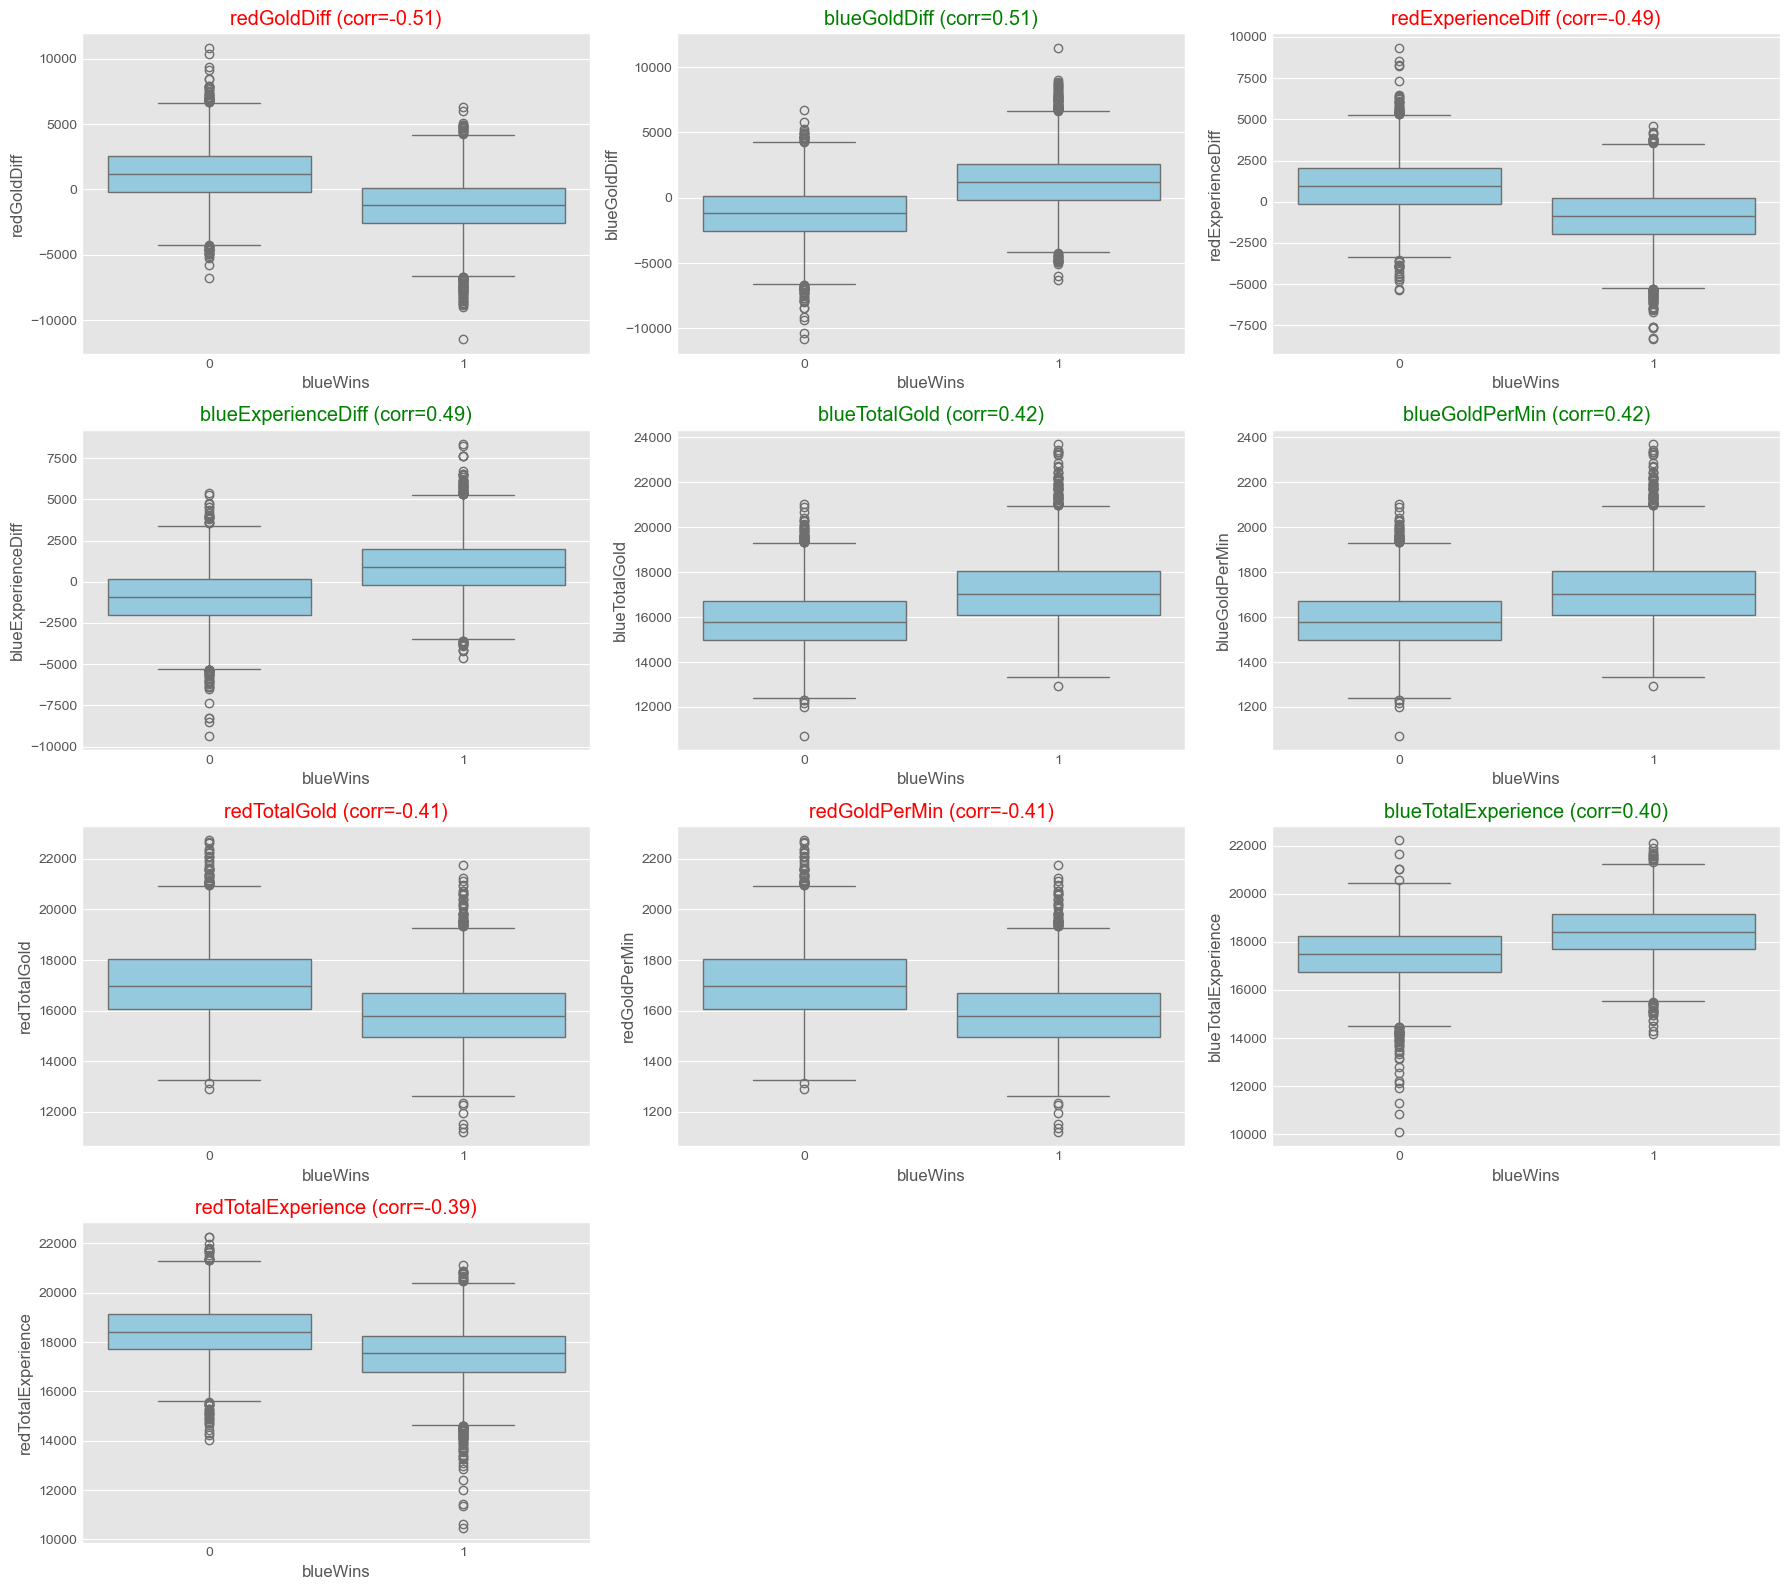

In [47]:
# seleciona top 10 features mais correlacionadas com 'blueWins' (sem abs para plotar valores originais)
selected_features = target_corr[1:11].index.tolist()

n = len(selected_features)
ncols = 3
nrows = math.ceil(n / ncols)

fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*6, nrows*4))
axes = axes.flatten()  # facilita iterar mesmo que haja só 1 linha

for i, col in enumerate(selected_features):
    sns.boxplot(x="blueWins", y=col, data=df, ax=axes[i], color='skyblue')
    corr = corr_matrix.at[col, 'blueWins']
    axes[i].set_title(f"{col} (corr={corr:.2f})", color='green' if corr>0 else 'red')

# esconder axes extras caso n < nrows*ncols
for j in range(n, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

#### Pelos gráficos acima, podemos ver que as features que mais impactam a chance de vitória do time azul são a diferença de gold e a diferença de experiência. Isso é esperado, pois a diferença de gold permite comprar mais itens e a diferença de level aumenta os atributos dos campeões, tornando-os mais poderosos e aumentando a chance de vitória em uma eventual teamfight.

### FEATURE ENGINEERING

In [48]:
def create_enhanced_features(df_input):
    """Criar features avançadas para melhorar o desempenho dos modelos"""
    df_out = df_input.copy()
    
    # Métricas de desempenho em combate
    df_out['blueKDA'] = (df_out['blueKills'] + df_out['blueAssists']) / (df_out['blueDeaths'] + 1e-6)
    df_out['redKDA'] = (df_out['redKills'] + df_out['redAssists']) / (df_out['redDeaths'] + 1e-6)
    
    # Diferenças estratégicas
    df_out['killDiff'] = df_out['blueKills'] - df_out['redKills']
    df_out['assistDiff'] = df_out['blueAssists'] - df_out['redAssists']
    df_out['deathDiff'] = df_out['blueDeaths'] - df_out['redDeaths']
    df_out['wardDiff'] = df_out['blueWardsPlaced'] - df_out['redWardsPlaced']
    df_out['dragonDiff'] = df_out['blueDragons'] - df_out['redDragons']
    df_out['heraldDiff'] = df_out['blueHeralds'] - df_out['redHeralds']
    
    # Vantagens econômicas
    df_out['goldPerMinDiff'] = df_out['blueGoldPerMin'] - df_out['redGoldPerMin']
    df_out['expDiff'] = df_out['blueTotalExperience'] - df_out['redTotalExperience']
    df_out['levelDiff'] = df_out['blueAvgLevel'] - df_out['redAvgLevel']
    
    # Controle de objetivos
    df_out['eliteMonstersDiff'] = df_out['blueEliteMonsters'] - df_out['redEliteMonsters']
    df_out['totalObjectives'] = (df_out['blueDragons'] + df_out['blueHeralds'] + 
                                df_out['redDragons'] + df_out['redHeralds'])
    
    # Eficiência de farm
    df_out['blueCSPerMin'] = df_out['blueTotalMinionsKilled'] / 10  # Assumindo 10 minutos
    df_out['redCSPerMin'] = df_out['redTotalMinionsKilled'] / 10
    df_out['csDiff'] = df_out['blueCSPerMin'] - df_out['redCSPerMin']
    
    return df_out

# Aplicar feature engineering
df_enhanced = create_enhanced_features(df)
print(f"\nDataset após feature engineering: {df_enhanced.shape}")

# Mostrar correlações das novas features com a variável alvo
new_features = ['killDiff', 'goldPerMinDiff', 'dragonDiff', 'wardDiff', 'levelDiff']
correlations = df_enhanced[new_features + ['blueWins']].corr()['blueWins'].sort_values(ascending=False)
print("\nCorrelações das principais features criadas com blueWins:")
print(correlations.drop('blueWins'))  # Exclui a própria variável alvo


Dataset após feature engineering: (9879, 54)

Correlações das principais features criadas com blueWins:
goldPerMinDiff    0.511119
killDiff          0.479379
levelDiff         0.452927
dragonDiff        0.234264
wardDiff          0.016890
Name: blueWins, dtype: float64


### PREPARAÇÃO DOS DADOS

In [49]:
def prepare_dataset(df_enhanced):
    """
    Prepara o dataset para machine learning com divisão, normalização e balanceamento.
    
    Args:
        df_enhanced: DataFrame com os dados processados
    
    Returns:
        tuple: (X_train_balanced, X_test_scaled, y_train_balanced, y_test, scaler)
    """
    
    # Definir features e target
    X = df_enhanced.drop(['gameId', 'blueWins'], axis=1)
    y = df_enhanced['blueWins']
    
    print("=" * 60)
    print("INFORMAÇÕES DO DATASET")
    print("=" * 60)
    print(f"Features: {X.shape[1]} variáveis")
    print(f"Amostras: {X.shape[0]} registros")
    print(f"Variável Target: {y.name}")
    print(f"Dimensões das features: {X.shape}")
    
    # Verificar distribuição original
    print(f"\nDistribuição original da target:")
    unique_orig, counts_orig = np.unique(y, return_counts=True)
    for u, c in zip(unique_orig, counts_orig):
        print(f"   Classe {u}: {c} amostras ({c/len(y)*100:.1f}%)")
    
    # Divisão treino/teste
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, 
        test_size=0.2, 
        random_state=42, 
        stratify=y
    )
    
    # Normalização dos dados
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Balanceamento com SMOTE
    smote = SMOTE(random_state=42)
    X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)
    
    print("\n" + "=" * 60)
    print("RESULTADOS DO PROCESSAMENTO")
    print("=" * 60)
    
    # Distribuição após balanceamento
    print(f"Distribuição após balanceamento SMOTE:")
    unique_bal, counts_bal = np.unique(y_train_balanced, return_counts=True)
    for u, c in zip(unique_bal, counts_bal):
        print(f"   Classe {u}: {c:} amostras ({c/len(y_train_balanced)*100:.1f}%)")
    
    # Divisão final dos dados
    print(f"\nDivisão final dos dados:")
    print(f"Treino: {X_train_balanced.shape[0]:} amostras ({X_train_balanced.shape[0]/len(X)*100:.1f}%)")
    print(f"Teste: {X_test_scaled.shape[0]:} amostras ({X_test_scaled.shape[0]/len(X)*100:.1f}%)")
    
    # Distribuição nos conjuntos finais
    print(f"\nDistribuição final nos conjuntos:")
    train_counts = np.bincount(y_train_balanced.astype(int))
    test_counts = np.bincount(y_test.astype(int))
    
    print(f"   Treino (balanceado): {train_counts}")
    print(f"   Teste (original): {test_counts}")
    
    print("\nPreparação dos dados concluída!")
    print("=" * 60)
    
    return X_train_balanced, X_test_scaled, y_train_balanced, y_test, scaler

# Executar a preparação
X_train_balanced, X_test_scaled, y_train_balanced, y_test, scaler = prepare_dataset(df_enhanced)

INFORMAÇÕES DO DATASET
Features: 52 variáveis
Amostras: 9879 registros
Variável Target: blueWins
Dimensões das features: (9879, 52)

Distribuição original da target:
   Classe 0: 4949 amostras (50.1%)
   Classe 1: 4930 amostras (49.9%)

RESULTADOS DO PROCESSAMENTO
Distribuição após balanceamento SMOTE:
   Classe 0: 3959 amostras (50.0%)
   Classe 1: 3959 amostras (50.0%)

Divisão final dos dados:
Treino: 7918 amostras (80.1%)
Teste: 1976 amostras (20.0%)

Distribuição final nos conjuntos:
   Treino (balanceado): [3959 3959]
   Teste (original): [990 986]

Preparação dos dados concluída!


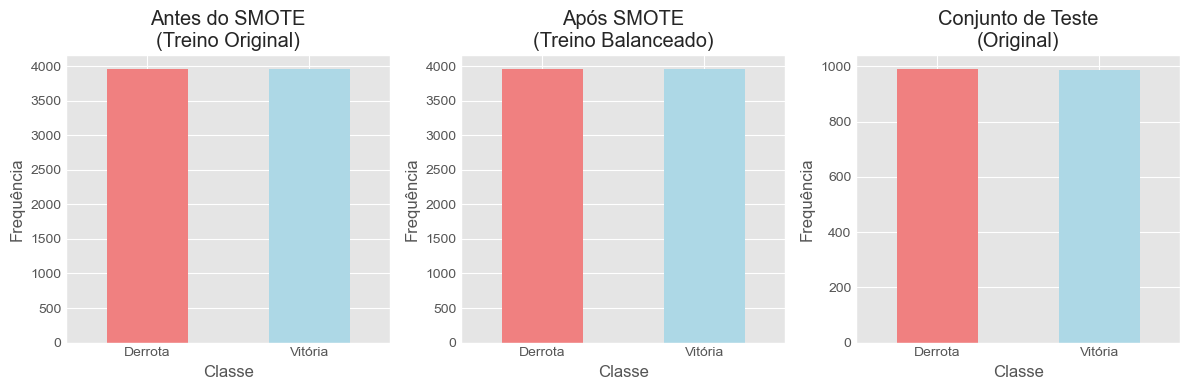

In [50]:
# Visualizar o impacto do balanceamento
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
y_train_balanced.value_counts().plot(kind='bar', color=['lightcoral', 'lightblue'])
plt.title('Antes do SMOTE\n(Treino Original)')
plt.xlabel('Classe')
plt.ylabel('Frequência')
plt.xticks([0, 1], ['Derrota', 'Vitória'], rotation=0)

plt.subplot(1, 3, 2)
pd.Series(y_train_balanced).value_counts().plot(kind='bar', color=['lightcoral', 'lightblue'])
plt.title('Após SMOTE\n(Treino Balanceado)')
plt.xlabel('Classe')
plt.ylabel('Frequência')
plt.xticks([0, 1], ['Derrota', 'Vitória'], rotation=0)

plt.subplot(1, 3, 3)
y_test.value_counts().plot(kind='bar', color=['lightcoral', 'lightblue'])
plt.title('Conjunto de Teste\n(Original)')
plt.xlabel('Classe')
plt.ylabel('Frequência')
plt.xticks([0, 1], ['Derrota', 'Vitória'], rotation=0)

plt.tight_layout()
plt.show()

### TREINAMENTO DOS MODELOS SOLICITADOS E VALIDAÇÃO CRUZADA

In [51]:
# Definir modelos
models = {
        'Regressão Logística': LogisticRegression(random_state=42, max_iter=1000),
        'Naive Bayes': GaussianNB(),
        'Árvore de Decisão': DecisionTreeClassifier(random_state=42)
    }

In [52]:
 # Configuração da validação cruzada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [53]:
def create_model_visualizations(y_test, y_pred, y_pred_proba, model_name, 
                               auc_score, accuracy, f1, precision, recall):
    """
    Cria visualizações completas para análise do modelo
    """
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle(f'Análise Completa - {model_name}', fontsize=16, fontweight='bold')
    
    # 1. Matriz de Confusão
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax1,
                annot_kws={'size': 14})
    ax1.set_title('Matriz de Confusão')
    ax1.set_xlabel('Predito')
    ax1.set_ylabel('Real')
    ax1.set_xticklabels(['Derrota', 'Vitória'])
    ax1.set_yticklabels(['Derrota', 'Vitória'])
    
    # 2. Curva ROC
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    ax2.plot(fpr, tpr, color='darkorange', lw=2, 
             label=f'ROC (AUC = {auc_score:.3f})')
    ax2.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', alpha=0.6)
    ax2.set_xlabel('Taxa de Falsos Positivos')
    ax2.set_ylabel('Taxa de Verdadeiros Positivos')
    ax2.set_title('Curva ROC')
    ax2.legend(loc="lower right")
    ax2.grid(True, alpha=0.3)
    
    # 3. Distribuição de Probabilidades
    ax3.hist(y_pred_proba[y_test == 0], bins=30, alpha=0.7, 
             label='Classe 0 (Derrota)', color='red', density=True)
    ax3.hist(y_pred_proba[y_test == 1], bins=30, alpha=0.7, 
             label='Classe 1 (Vitória)', color='blue', density=True)
    ax3.set_xlabel('Probabilidade Predita')
    ax3.set_ylabel('Densidade')
    ax3.set_title('Distribuição das Probabilidades')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # 4. Métricas Comparativas
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']
    values = [accuracy, precision, recall, f1, auc_score]
    colors = plt.cm.viridis(np.linspace(0, 1, len(metrics)))
    
    bars = ax4.bar(metrics, values, color=colors)
    ax4.set_ylim(0, 1)
    ax4.set_title('Resumo das Métricas')
    ax4.set_ylabel('Score')
    ax4.grid(True, alpha=0.3, axis='y')
    
    # Adicionar valores nas barras
    for bar, value in zip(bars, values):
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{value:.3f}', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()

In [54]:
# Dicionário para armazenar todos os resultados
all_results = {}

def evaluate_model_comprehensive(model, X_train, y_train, X_test, y_test, model_name):
    """
    Função completa para avaliar modelos com validação cruzada detalhada e visualizações
    
    Args:
        model: Modelo de ML a ser avaliado
        X_train: Features de treino
        y_train: Target de treino
        X_test: Features de teste
        y_test: Target de teste
        model_name: Nome do modelo para identificação
    
    Returns:
        model: Modelo treinado
    """
    
    print(f"\nAVALIANDO: {model_name.upper()}")
    print("="*60)
    
    
    # === VALIDAÇÃO CRUZADA COMPLETA ===
    print("  Executando Validação Cruzada...")
    
    # Calcular múltiplas métricas com validação cruzada
    cv_auc_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='roc_auc', n_jobs=-1)
    cv_accuracy_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy', n_jobs=-1)
    cv_f1_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='f1', n_jobs=-1)
    cv_precision_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='precision', n_jobs=-1)
    cv_recall_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='recall', n_jobs=-1)
    
    # Exibir resultados da validação cruzada
    print(f"   Validação Cruzada (5-folds):")
    print(f"   AUC: {cv_auc_scores.mean():.4f} (±{cv_auc_scores.std() * 2:.4f})")
    print(f"   Accuracy: {cv_accuracy_scores.mean():.4f} (±{cv_accuracy_scores.std() * 2:.4f})")
    print(f"   F1-Score: {cv_f1_scores.mean():.4f} (±{cv_f1_scores.std() * 2:.4f})")
    print(f"   Precision: {cv_precision_scores.mean():.4f} (±{cv_precision_scores.std() * 2:.4f})")
    print(f"   Recall: {cv_recall_scores.mean():.4f} (±{cv_recall_scores.std() * 2:.4f})")
    
    # === TREINO E AVALIAÇÃO NO CONJUNTO DE TESTE ===
    print("\nTreinando e testando...")
    
    # Treinar modelo
    model.fit(X_train, y_train)
    
    # Predições
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Métricas no conjunto de teste
    test_auc = roc_auc_score(y_test, y_pred_proba)
    test_accuracy = accuracy_score(y_test, y_pred)
    test_f1 = f1_score(y_test, y_pred)
    test_precision = precision_score(y_test, y_pred)
    test_recall = recall_score(y_test, y_pred)
    
    print(f"   Métricas no Conjunto de Teste:")
    print(f"   AUC: {test_auc:.4f}")
    print(f"   Acurácia: {test_accuracy:.4f}")
    print(f"   F1-Score: {test_f1:.4f}")
    print(f"   Precisão: {test_precision:.4f}")
    print(f"   Recall: {test_recall:.4f}")
    
    # === VISUALIZAÇÕES ===
    create_model_visualizations(y_test, y_pred, y_pred_proba, model_name, 
                               test_auc, test_accuracy, test_f1, test_precision, test_recall)
    
    # === RELATÓRIO DETALHADO ===
    print(f"\nRelatório de Classificação Detalhado:")
    print(classification_report(y_test, y_pred, target_names=['Derrota', 'Vitória']))
    
    # === ARMAZENAR RESULTADOS ===
    all_results[model_name] = {
        # Validação Cruzada
        'CV_AUC_mean': cv_auc_scores.mean(),
        'CV_AUC_std': cv_auc_scores.std(),
        'CV_Accuracy_mean': cv_accuracy_scores.mean(),
        'CV_Accuracy_std': cv_accuracy_scores.std(),
        'CV_F1_mean': cv_f1_scores.mean(),
        'CV_F1_std': cv_f1_scores.std(),
        'CV_Precision_mean': cv_precision_scores.mean(),
        'CV_Precision_std': cv_precision_scores.std(),
        'CV_Recall_mean': cv_recall_scores.mean(),
        'CV_Recall_std': cv_recall_scores.std(),
        # Teste
        'Test_AUC': test_auc,
        'Test_Accuracy': test_accuracy,
        'Test_F1': test_f1,
        'Test_Precision': test_precision,
        'Test_Recall': test_recall,
        'y_pred_proba': y_pred_proba,
        'Model': model
    }
    
    print(f"\n{model_name} avaliado com sucesso!")
    return model

In [55]:
def create_final_comparison():
    """
    Cria comparação final entre todos os modelos
    """
    print("\n" + "="*80)
    print("COMPARAÇÃO DOS MODELOS")
    print("="*80)
  
    
    comparison_data = []
    for model_name, results in all_results.items():
        comparison_data.append({
            'Modelo': model_name,
            'CV_AUC': f"{results['CV_AUC_mean']:.4f} (±{results['CV_AUC_std']:.4f})",
            'Test_AUC': f"{results['Test_AUC']:.4f}",
            'Test_Accuracy': f"{results['Test_Accuracy']:.4f}",
            'Test_F1': f"{results['Test_F1']:.4f}",
            'Test_Precision': f"{results['Test_Precision']:.4f}",
            'Test_Recall': f"{results['Test_Recall']:.4f}"
        })
    
    df_comparison = pd.DataFrame(comparison_data)
    print(df_comparison.to_string(index=False))
    
    # Encontrar melhor modelo
    best_model_auc = max(all_results.items(), key=lambda x: x[1]['Test_AUC'])
    best_model_f1 = max(all_results.items(), key=lambda x: x[1]['Test_F1'])
    
    print(f"\nMELHORES RESULTADOS:")
    print(f"   Melhor AUC: {best_model_auc[0]} ({best_model_auc[1]['Test_AUC']:.4f})")
    print(f"   Melhor F1: {best_model_f1[0]} ({best_model_f1[1]['Test_F1']:.4f})")
    
    return df_comparison

In [56]:
def run_complete_evaluation(model_dict, X_train_balanced, y_train_balanced, X_test_scaled, y_test):
    """
    Executa avaliação completa de todos os modelos
    """
    print("\n" + "="*80)
    print("AVALIAÇÃO DE MODELOS DE ML")
    print("="*80)
    
    trained_models = {}
    
    # Avaliar cada modelo
    for name, model in model_dict.items():
        trained_models[name] = evaluate_model_comprehensive(
            model, X_train_balanced, y_train_balanced, 
            X_test_scaled, y_test, name
        )
    
    # Comparação final
    create_final_comparison()
    
    return trained_models


AVALIAÇÃO DE MODELOS DE ML

AVALIANDO: REGRESSÃO LOGÍSTICA
  Executando Validação Cruzada...
   Validação Cruzada (5-folds):
   AUC: 0.8108 (±0.0200)
   Accuracy: 0.7335 (±0.0292)
   F1-Score: 0.7332 (±0.0296)
   Precision: 0.7341 (±0.0303)
   Recall: 0.7325 (±0.0344)

Treinando e testando...
   Métricas no Conjunto de Teste:
   AUC: 0.8057
   Acurácia: 0.7161
   F1-Score: 0.7179
   Precisão: 0.7119
   Recall: 0.7241


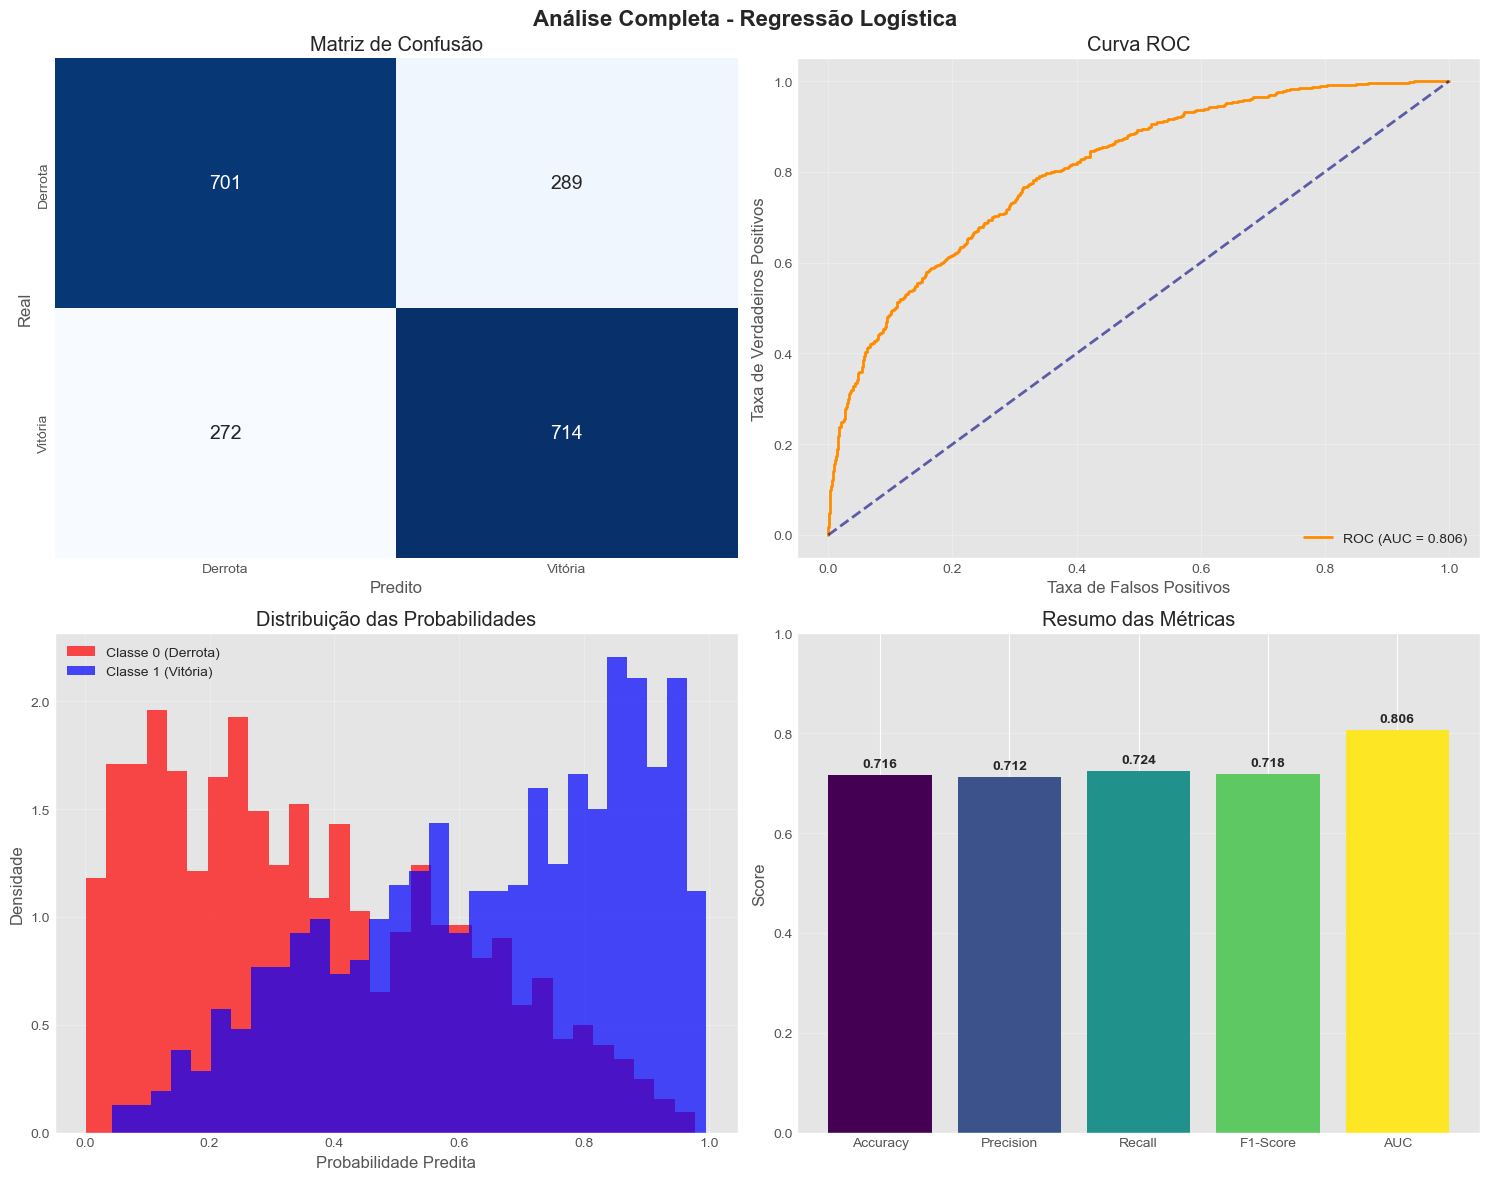


Relatório de Classificação Detalhado:
              precision    recall  f1-score   support

     Derrota       0.72      0.71      0.71       990
     Vitória       0.71      0.72      0.72       986

    accuracy                           0.72      1976
   macro avg       0.72      0.72      0.72      1976
weighted avg       0.72      0.72      0.72      1976


Regressão Logística avaliado com sucesso!

AVALIANDO: NAIVE BAYES
  Executando Validação Cruzada...
   Validação Cruzada (5-folds):
   AUC: 0.8035 (±0.0160)
   Accuracy: 0.7301 (±0.0224)
   F1-Score: 0.7284 (±0.0247)
   Precision: 0.7331 (±0.0243)
   Recall: 0.7239 (±0.0378)

Treinando e testando...
   Métricas no Conjunto de Teste:
   AUC: 0.7993
   Acurácia: 0.7171
   F1-Score: 0.7149
   Precisão: 0.7190
   Recall: 0.7110


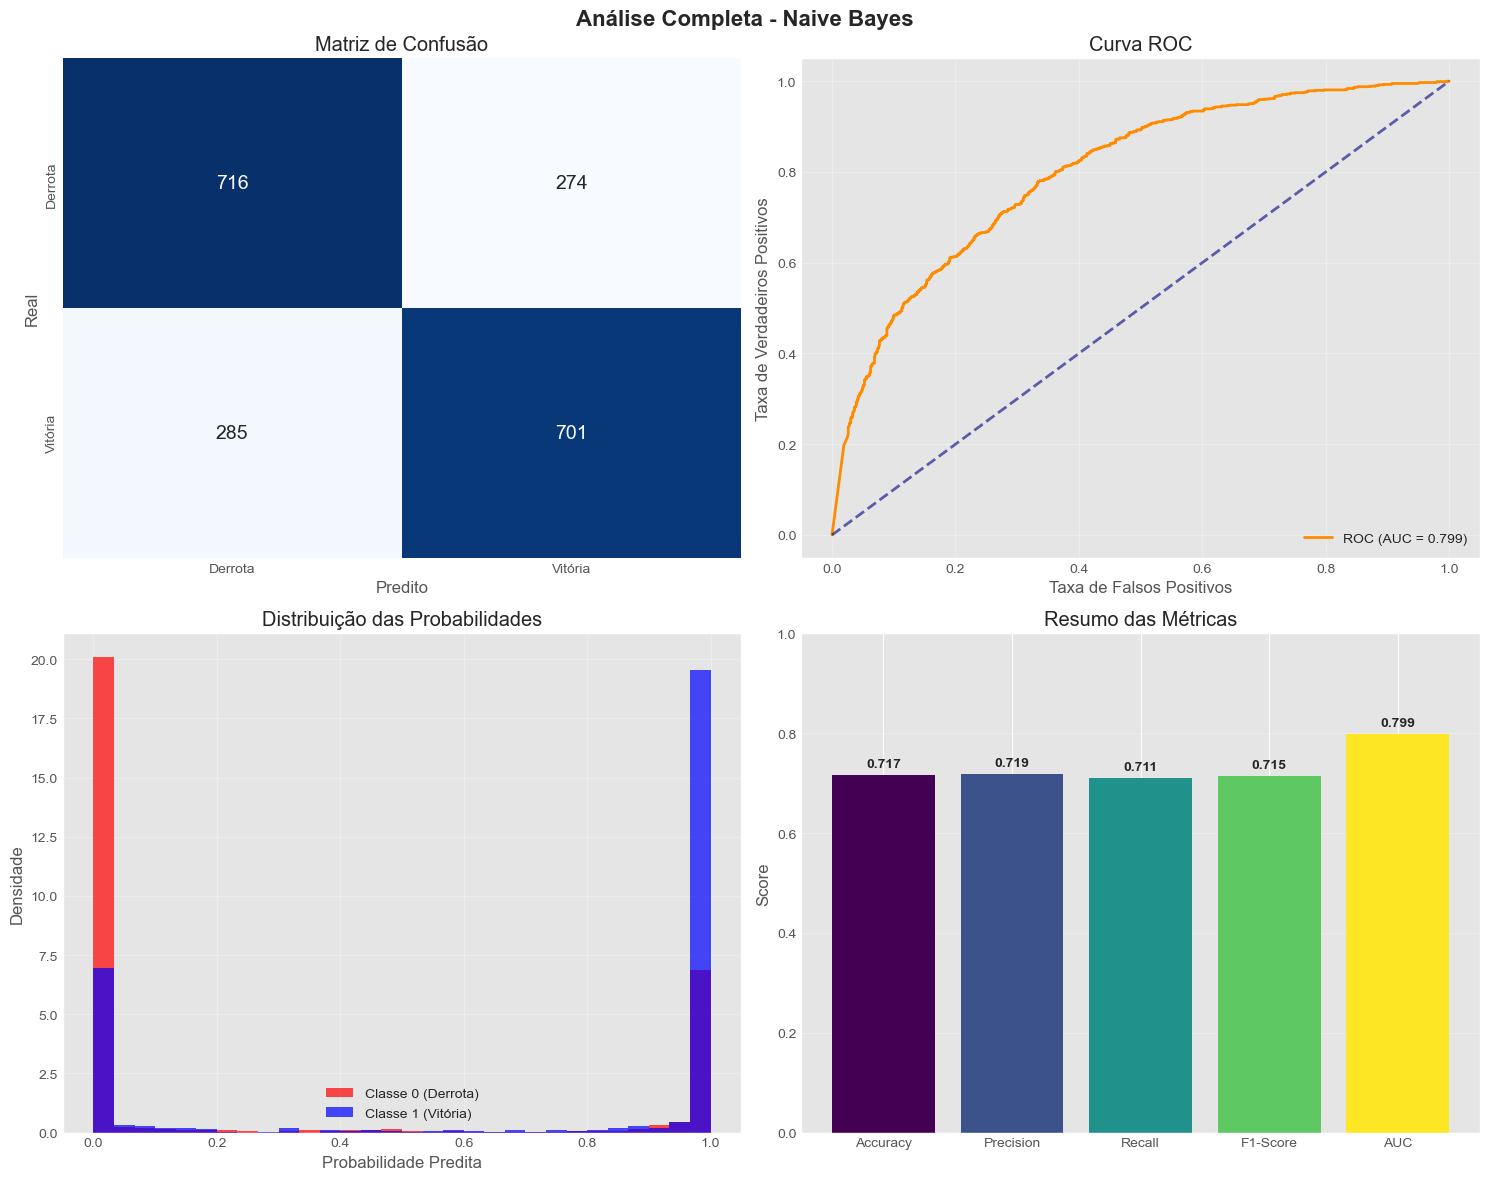


Relatório de Classificação Detalhado:
              precision    recall  f1-score   support

     Derrota       0.72      0.72      0.72       990
     Vitória       0.72      0.71      0.71       986

    accuracy                           0.72      1976
   macro avg       0.72      0.72      0.72      1976
weighted avg       0.72      0.72      0.72      1976


Naive Bayes avaliado com sucesso!

AVALIANDO: ÁRVORE DE DECISÃO
  Executando Validação Cruzada...
   Validação Cruzada (5-folds):
   AUC: 0.6388 (±0.0317)
   Accuracy: 0.6388 (±0.0317)
   F1-Score: 0.6366 (±0.0287)
   Precision: 0.6407 (±0.0349)
   Recall: 0.6327 (±0.0261)

Treinando e testando...
   Métricas no Conjunto de Teste:
   AUC: 0.6498
   Acurácia: 0.6498
   F1-Score: 0.6547
   Precisão: 0.6444
   Recall: 0.6653


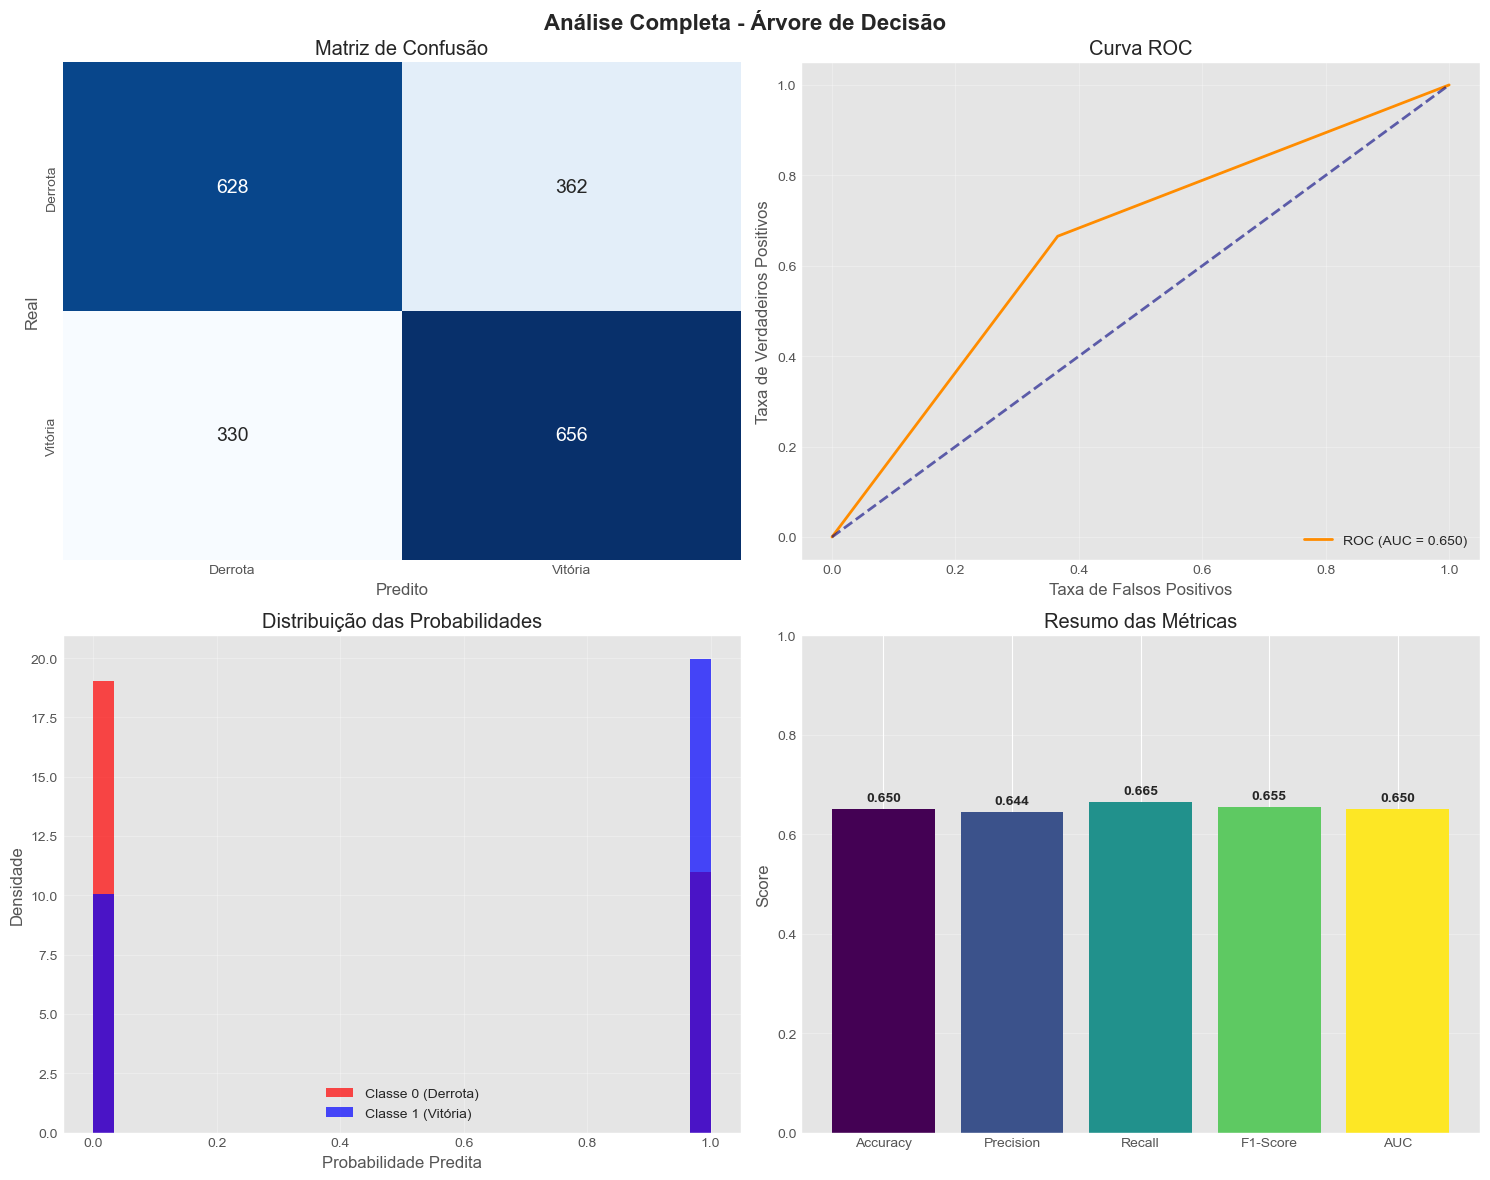


Relatório de Classificação Detalhado:
              precision    recall  f1-score   support

     Derrota       0.66      0.63      0.64       990
     Vitória       0.64      0.67      0.65       986

    accuracy                           0.65      1976
   macro avg       0.65      0.65      0.65      1976
weighted avg       0.65      0.65      0.65      1976


Árvore de Decisão avaliado com sucesso!

COMPARAÇÃO DOS MODELOS
             Modelo           CV_AUC Test_AUC Test_Accuracy Test_F1 Test_Precision Test_Recall
Regressão Logística 0.8108 (±0.0100)   0.8057        0.7161  0.7179         0.7119      0.7241
        Naive Bayes 0.8035 (±0.0080)   0.7993        0.7171  0.7149         0.7190      0.7110
  Árvore de Decisão 0.6388 (±0.0159)   0.6498        0.6498  0.6547         0.6444      0.6653

MELHORES RESULTADOS:
   Melhor AUC: Regressão Logística (0.8057)
   Melhor F1: Regressão Logística (0.7179)


In [57]:
# Executar avaliação completa
trained_models = run_complete_evaluation(models,
    X_train_balanced, y_train_balanced, 
    X_test_scaled, y_test
)

### OTIMIZAÇÃO DE HIPERPARÂMETROS COM GRID SEARCH

In [58]:
print("\n" + "="*60)
print("OTIMIZAÇÃO DE HIPERPARÂMETROS (GRID SEARCH)")
print("="*60)

# Definir grades de parâmetros para cada modelo
param_grids = {
    'Regressão Logística': {
        'C': [0.01, 0.1, 1, 10, 100],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear', 'saga'],
        'max_iter': [1000, 2000]
    },
    'Naive Bayes': {
        'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]
    },
    'Árvore de Decisão': {
        'criterion': ['gini', 'entropy'],
        'max_depth': [3, 5, 7, 10, 15, None],
        'min_samples_split': [2, 5, 10, 20],
        'min_samples_leaf': [1, 2, 4, 8],
        'max_features': ['sqrt', 'log2', None]
    }
}

# Realizar Grid Search para cada modelo
optimized_models = {}
grid_search_results = {}

for name, model in models.items():
    print(f"\n--- Otimizando {name} ---")
    
    # Grid Search com validação cruzada
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grids[name],
        cv=cv,
        scoring='roc_auc',
        n_jobs=-1,
        verbose=1
    )
    
    # Executar Grid Search
    grid_search.fit(X_train_balanced, y_train_balanced)
    
    # Armazenar melhor modelo
    optimized_models[name] = grid_search.best_estimator_
    
    # Armazenar resultados
    grid_search_results[name] = {
        'best_params': grid_search.best_params_,
        'best_cv_score': grid_search.best_score_,
        'cv_std': grid_search.cv_results_['std_test_score'][grid_search.best_index_]
    }
    
    print(f"Melhores parâmetros: {grid_search.best_params_}")
    print(f"Melhor CV AUC: {grid_search.best_score_:.4f} (±{grid_search.cv_results_['std_test_score'][grid_search.best_index_]:.4f})")


OTIMIZAÇÃO DE HIPERPARÂMETROS (GRID SEARCH)

--- Otimizando Regressão Logística ---
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Melhores parâmetros: {'C': 0.01, 'max_iter': 1000, 'penalty': 'l1', 'solver': 'saga'}
Melhor CV AUC: 0.8121 (±0.0084)

--- Otimizando Naive Bayes ---
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Melhores parâmetros: {'var_smoothing': 1e-09}
Melhor CV AUC: 0.8035 (±0.0080)

--- Otimizando Árvore de Decisão ---
Fitting 5 folds for each of 576 candidates, totalling 2880 fits
Melhores parâmetros: {'criterion': 'entropy', 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Melhor CV AUC: 0.8010 (±0.0074)


### AVALIAÇÃO DOS MODELOS OTIMIZADOS


AVALIAÇÃO DE MODELOS DE ML

AVALIANDO: REGRESSÃO LOGÍSTICA
  Executando Validação Cruzada...
   Validação Cruzada (5-folds):
   AUC: 0.8121 (±0.0168)
   Accuracy: 0.7374 (±0.0225)
   F1-Score: 0.7377 (±0.0269)
   Precision: 0.7367 (±0.0195)
   Recall: 0.7391 (±0.0427)

Treinando e testando...
   Métricas no Conjunto de Teste:
   AUC: 0.8060
   Acurácia: 0.7201
   F1-Score: 0.7217
   Precisão: 0.7163
   Recall: 0.7272


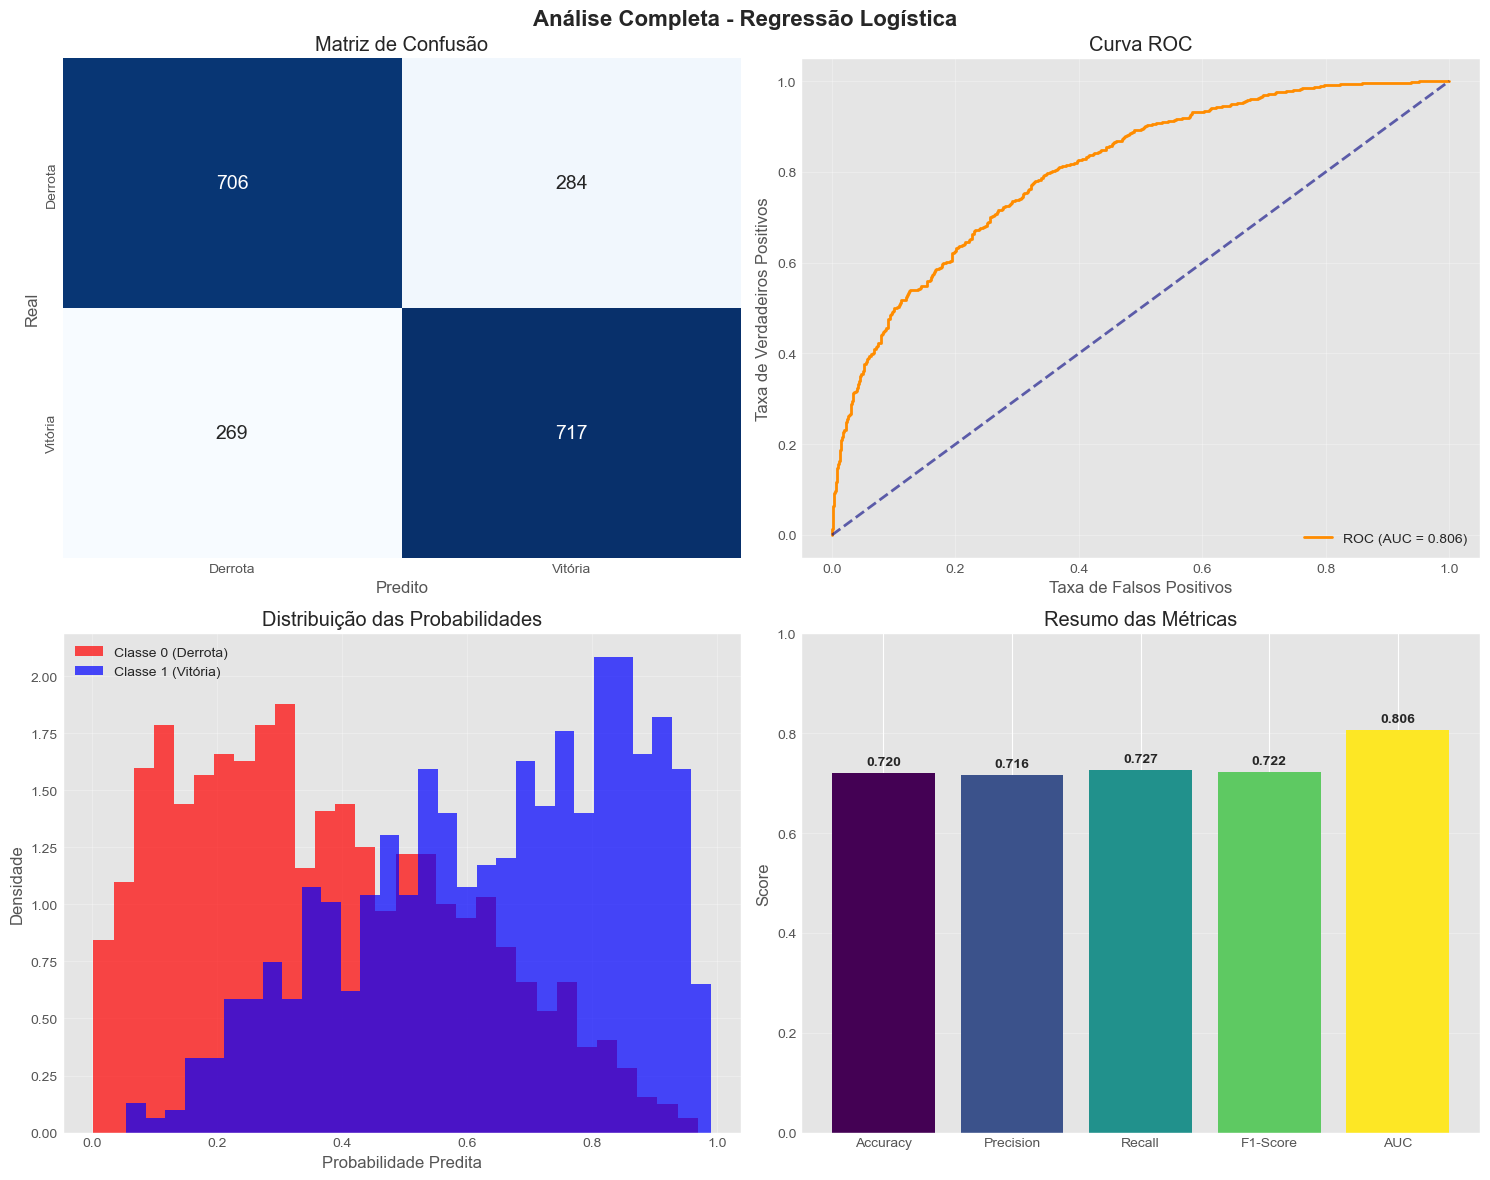


Relatório de Classificação Detalhado:
              precision    recall  f1-score   support

     Derrota       0.72      0.71      0.72       990
     Vitória       0.72      0.73      0.72       986

    accuracy                           0.72      1976
   macro avg       0.72      0.72      0.72      1976
weighted avg       0.72      0.72      0.72      1976


Regressão Logística avaliado com sucesso!

AVALIANDO: NAIVE BAYES
  Executando Validação Cruzada...
   Validação Cruzada (5-folds):
   AUC: 0.8035 (±0.0160)
   Accuracy: 0.7301 (±0.0224)
   F1-Score: 0.7284 (±0.0247)
   Precision: 0.7331 (±0.0243)
   Recall: 0.7239 (±0.0378)

Treinando e testando...
   Métricas no Conjunto de Teste:
   AUC: 0.7993
   Acurácia: 0.7171
   F1-Score: 0.7149
   Precisão: 0.7190
   Recall: 0.7110


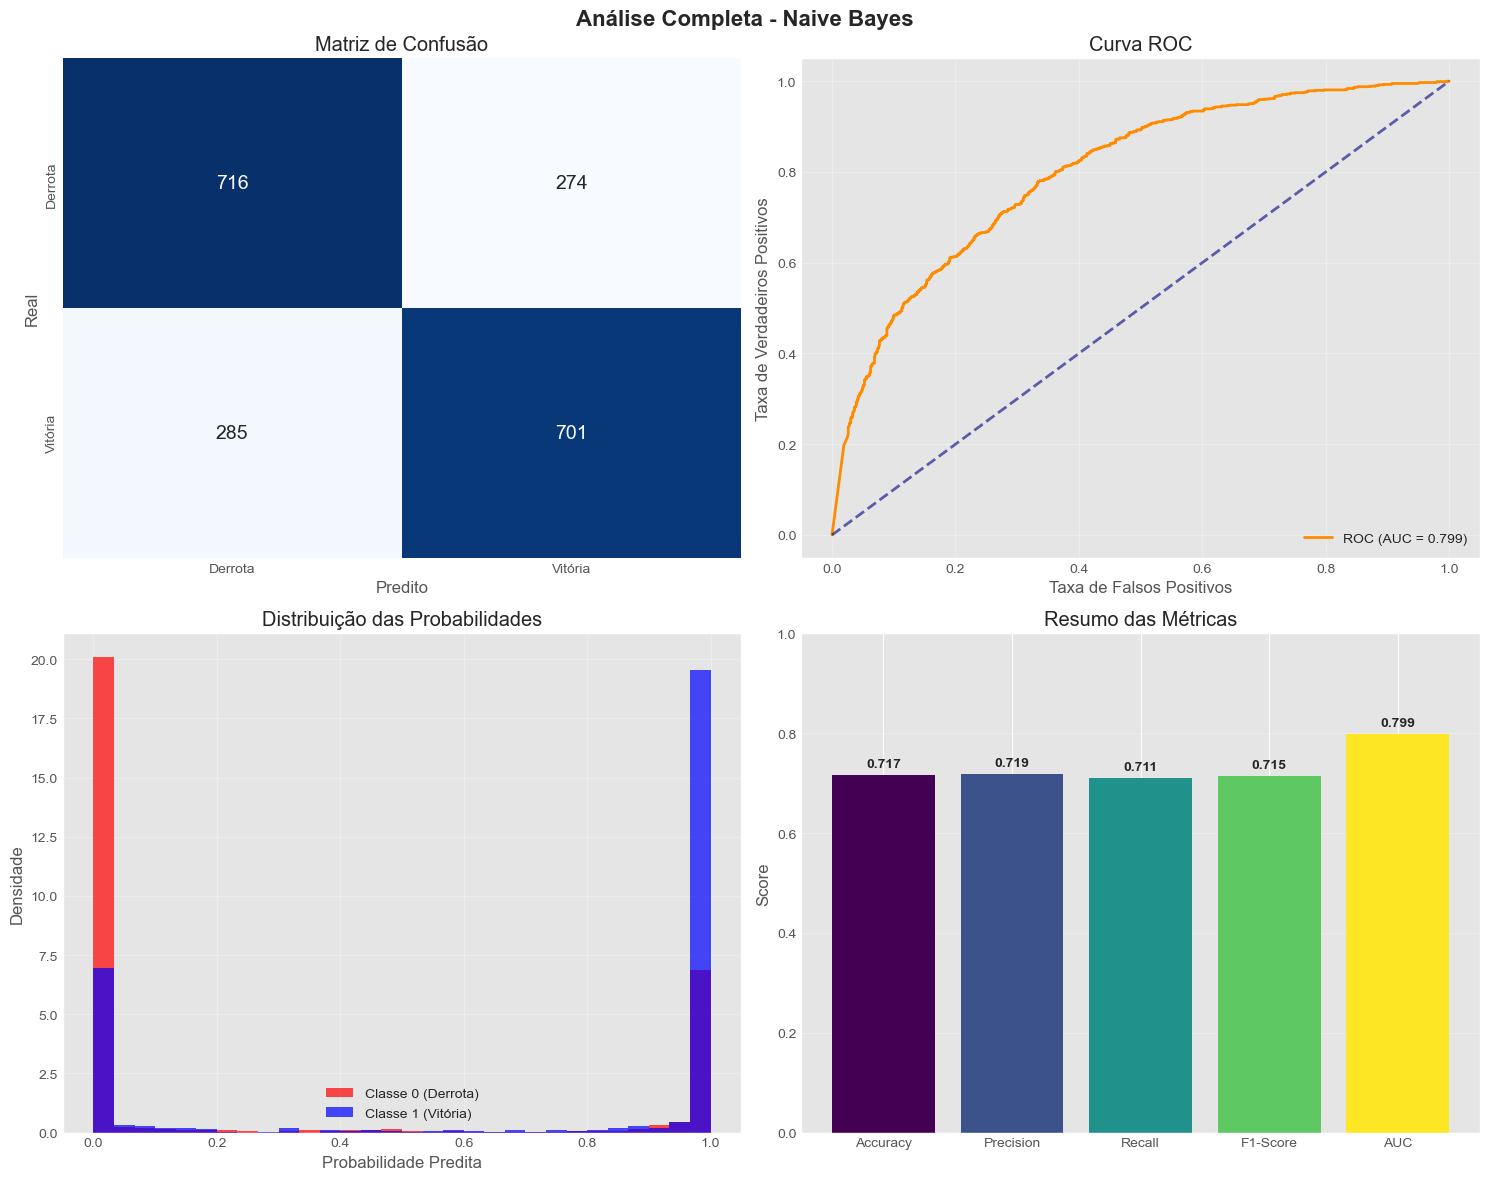


Relatório de Classificação Detalhado:
              precision    recall  f1-score   support

     Derrota       0.72      0.72      0.72       990
     Vitória       0.72      0.71      0.71       986

    accuracy                           0.72      1976
   macro avg       0.72      0.72      0.72      1976
weighted avg       0.72      0.72      0.72      1976


Naive Bayes avaliado com sucesso!

AVALIANDO: ÁRVORE DE DECISÃO
  Executando Validação Cruzada...
   Validação Cruzada (5-folds):
   AUC: 0.8010 (±0.0149)
   Accuracy: 0.7286 (±0.0171)
   F1-Score: 0.7224 (±0.0142)
   Precision: 0.7397 (±0.0298)
   Recall: 0.7062 (±0.0249)

Treinando e testando...
   Métricas no Conjunto de Teste:
   AUC: 0.7937
   Acurácia: 0.7186
   F1-Score: 0.7119
   Precisão: 0.7278
   Recall: 0.6968


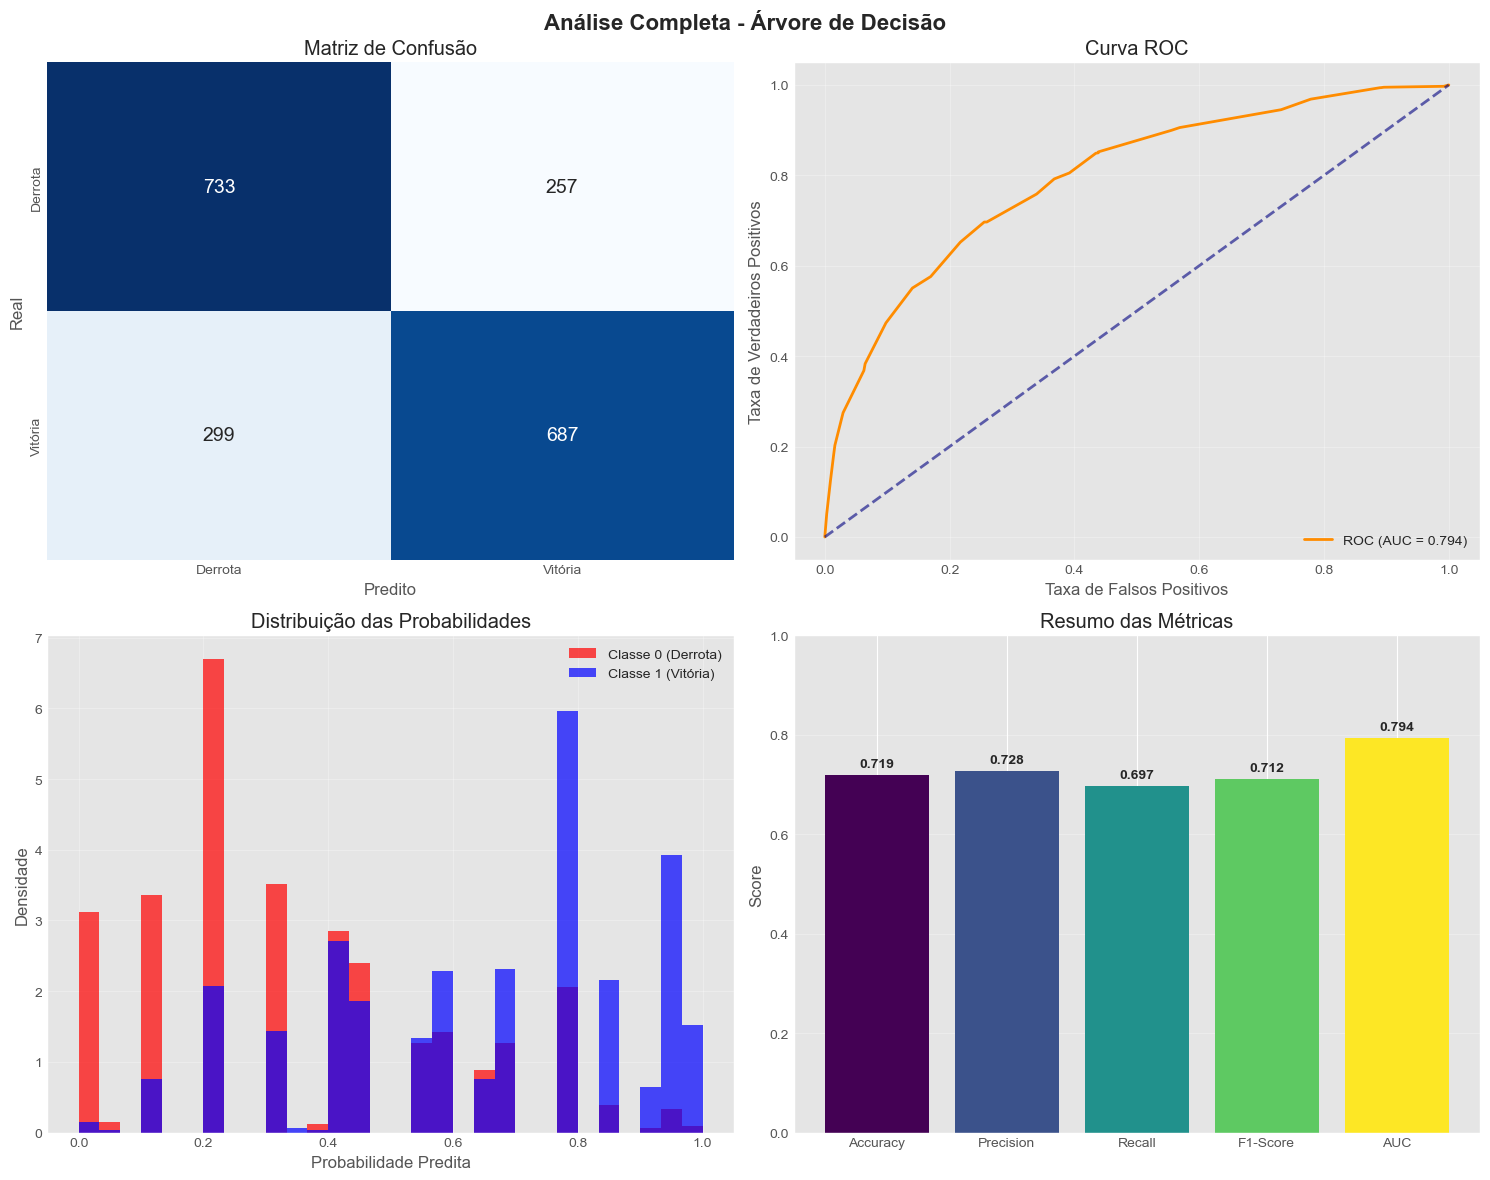


Relatório de Classificação Detalhado:
              precision    recall  f1-score   support

     Derrota       0.71      0.74      0.73       990
     Vitória       0.73      0.70      0.71       986

    accuracy                           0.72      1976
   macro avg       0.72      0.72      0.72      1976
weighted avg       0.72      0.72      0.72      1976


Árvore de Decisão avaliado com sucesso!

COMPARAÇÃO DOS MODELOS
             Modelo           CV_AUC Test_AUC Test_Accuracy Test_F1 Test_Precision Test_Recall
Regressão Logística 0.8121 (±0.0084)   0.8060        0.7201  0.7217         0.7163      0.7272
        Naive Bayes 0.8035 (±0.0080)   0.7993        0.7171  0.7149         0.7190      0.7110
  Árvore de Decisão 0.8010 (±0.0074)   0.7937        0.7186  0.7119         0.7278      0.6968

MELHORES RESULTADOS:
   Melhor AUC: Regressão Logística (0.8060)
   Melhor F1: Regressão Logística (0.7217)


In [59]:
# Avaliar modelos otimizados
resultados_otimizados = run_complete_evaluation(optimized_models, X_train_balanced, y_train_balanced, X_test_scaled, y_test)

### MODELOS DE ENSEMBLE PARA COMPARAÇÃO

In [60]:
print("\n" + "="*60)
print("MODELOS DE ENSEMBLE PARA COMPARAÇÃO")
print("="*60)

# Usar modelos otimizados no ensemble
optimized_ensemble_models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Voting Classifier (Otimizado)': VotingClassifier(
        estimators=[
            ('lr_opt', optimized_models['Regressão Logística']),
            ('nb_opt', optimized_models['Naive Bayes']),
            ('dt_opt', optimized_models['Árvore de Decisão'])
        ],
        voting='soft'
    ),
    'Stacking Classifier (Otimizado)': StackingClassifier(
        estimators=[
            ('lr_opt', optimized_models['Regressão Logística']),
            ('nb_opt', optimized_models['Naive Bayes']),
            ('dt_opt', optimized_models['Árvore de Decisão'])
        ],
        final_estimator=LogisticRegression(random_state=42),
        cv=cv
    )
}


MODELOS DE ENSEMBLE PARA COMPARAÇÃO



AVALIAÇÃO DE MODELOS DE ML

AVALIANDO: RANDOM FOREST
  Executando Validação Cruzada...
   Validação Cruzada (5-folds):
   AUC: 0.7994 (±0.0137)
   Accuracy: 0.7235 (±0.0212)
   F1-Score: 0.7192 (±0.0207)
   Precision: 0.7308 (±0.0251)
   Recall: 0.7080 (±0.0238)

Treinando e testando...
   Métricas no Conjunto de Teste:
   AUC: 0.7964
   Acurácia: 0.7151
   F1-Score: 0.7123
   Precisão: 0.7178
   Recall: 0.7069


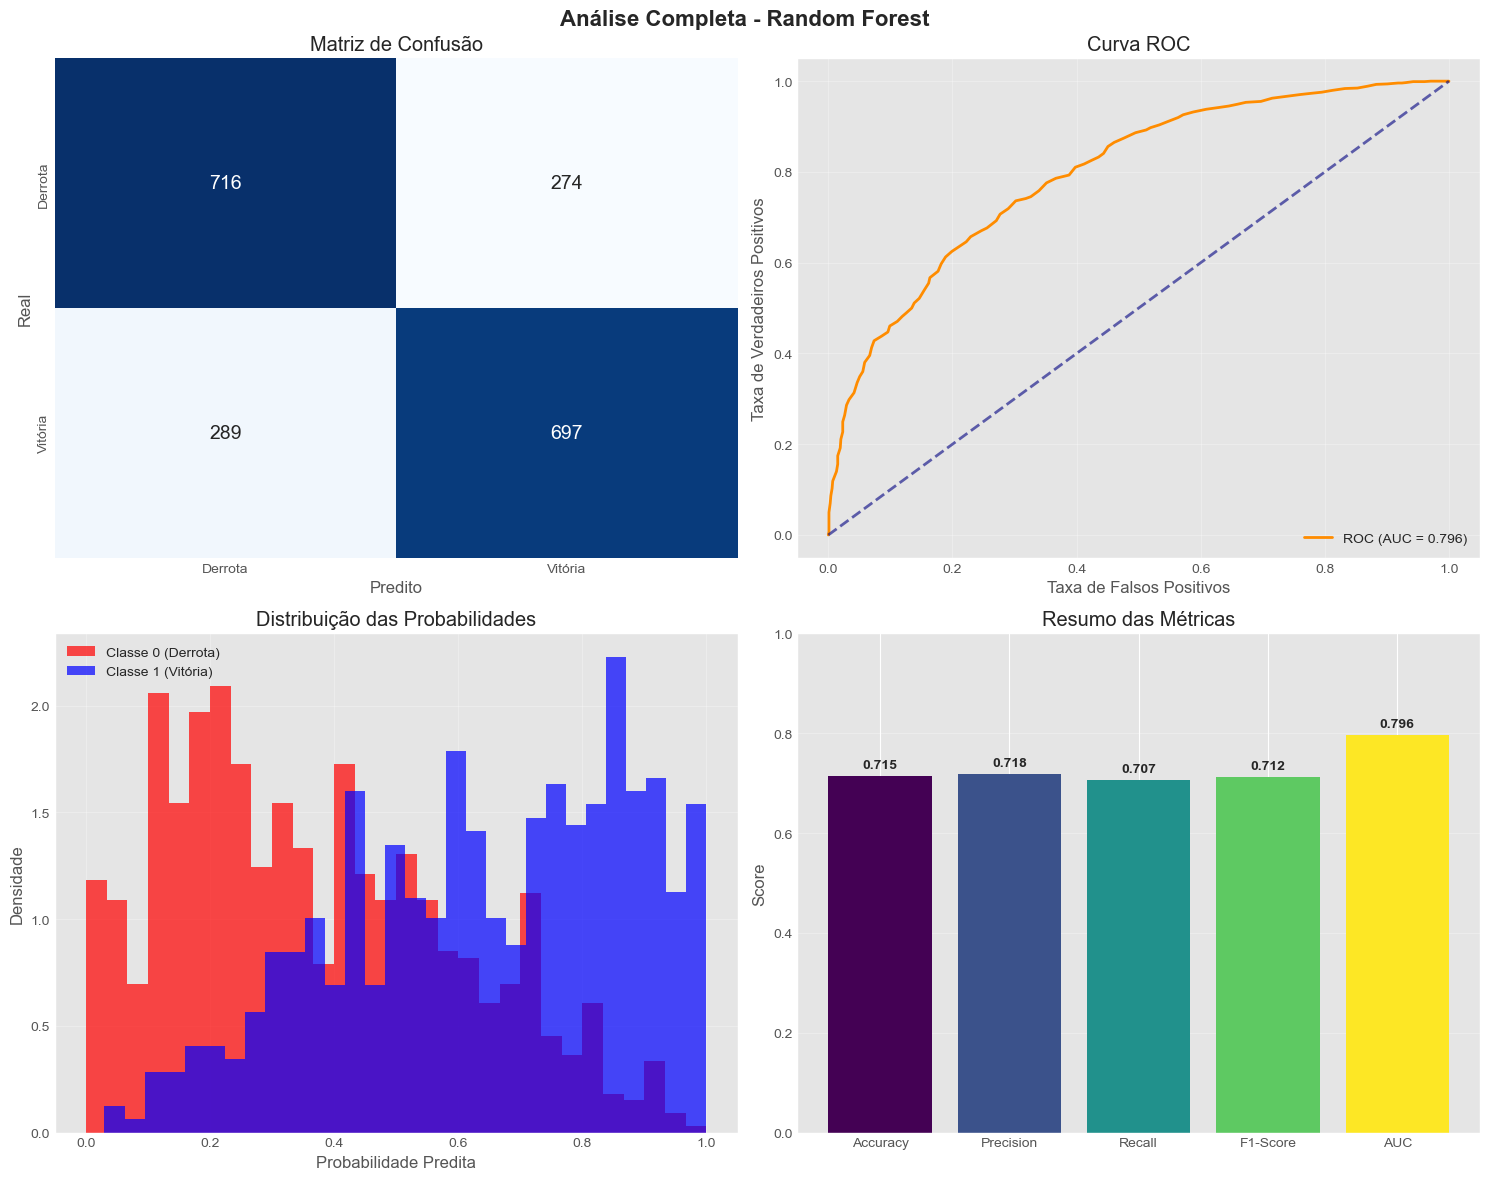


Relatório de Classificação Detalhado:
              precision    recall  f1-score   support

     Derrota       0.71      0.72      0.72       990
     Vitória       0.72      0.71      0.71       986

    accuracy                           0.72      1976
   macro avg       0.72      0.72      0.72      1976
weighted avg       0.72      0.72      0.72      1976


Random Forest avaliado com sucesso!

AVALIANDO: VOTING CLASSIFIER (OTIMIZADO)
  Executando Validação Cruzada...
   Validação Cruzada (5-folds):
   AUC: 0.8100 (±0.0156)
   Accuracy: 0.7314 (±0.0245)
   F1-Score: 0.7294 (±0.0260)
   Precision: 0.7348 (±0.0268)
   Recall: 0.7244 (±0.0371)

Treinando e testando...
   Métricas no Conjunto de Teste:
   AUC: 0.8025
   Acurácia: 0.7181
   F1-Score: 0.7165
   Precisão: 0.7191
   Recall: 0.7140


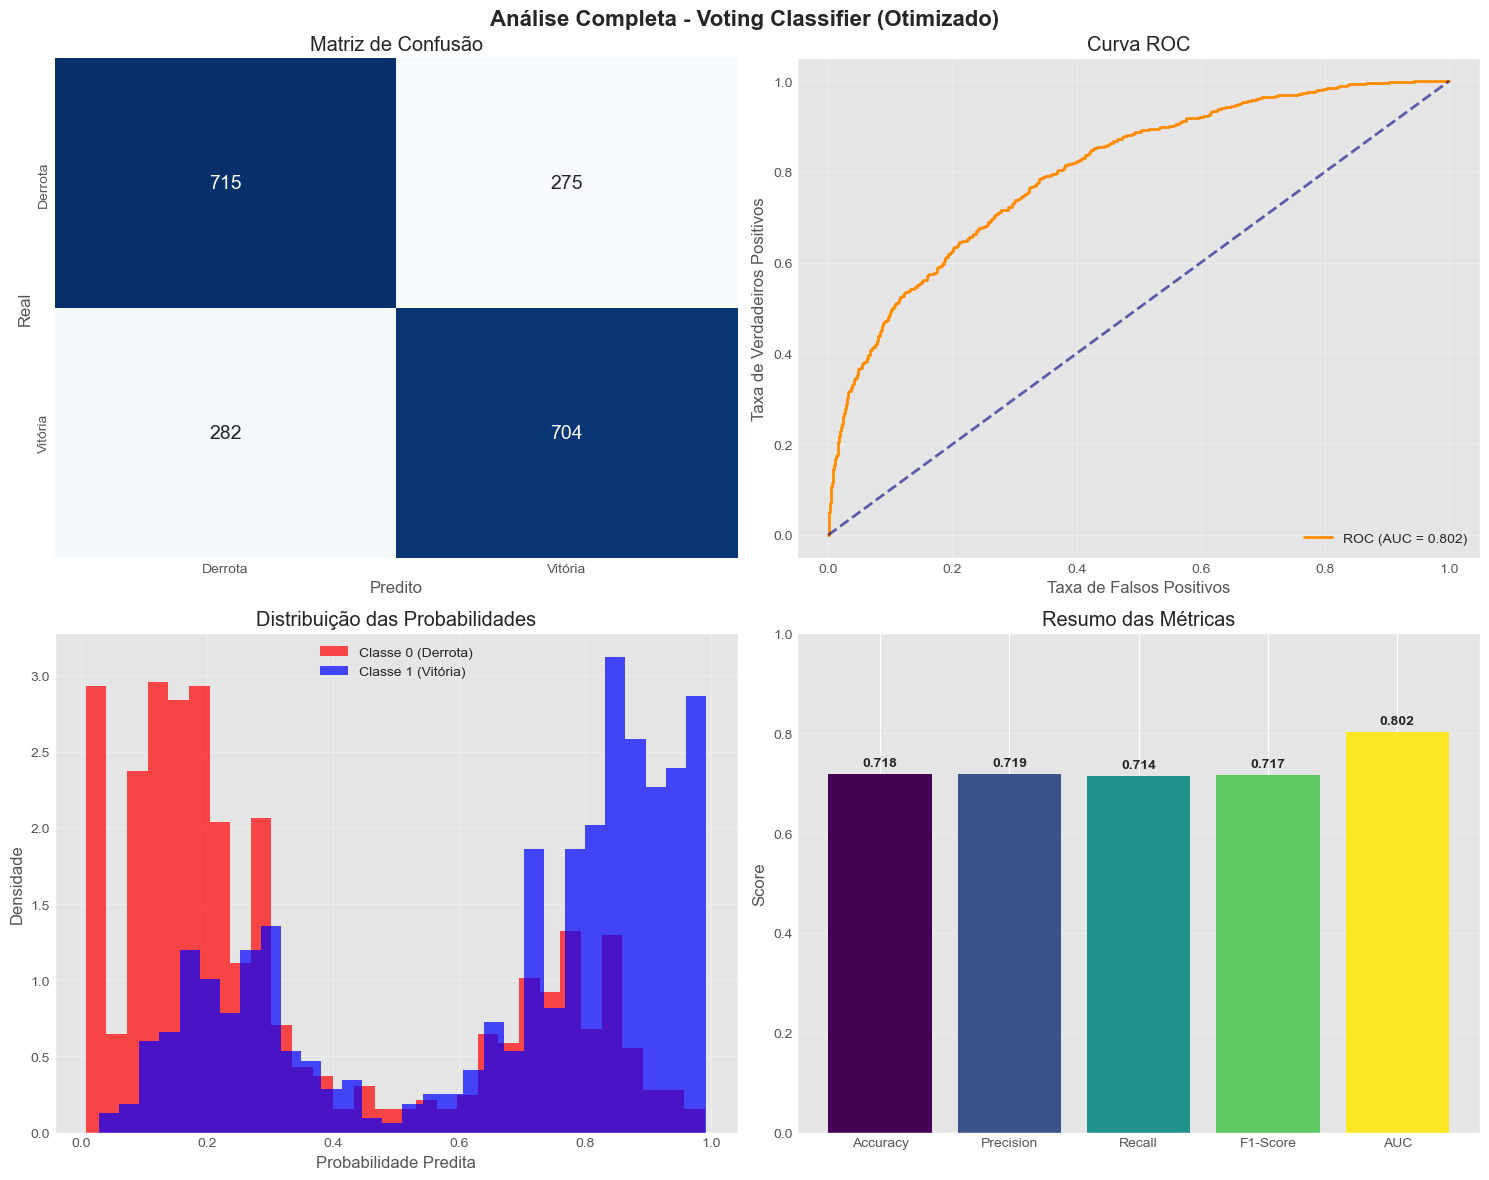


Relatório de Classificação Detalhado:
              precision    recall  f1-score   support

     Derrota       0.72      0.72      0.72       990
     Vitória       0.72      0.71      0.72       986

    accuracy                           0.72      1976
   macro avg       0.72      0.72      0.72      1976
weighted avg       0.72      0.72      0.72      1976


Voting Classifier (Otimizado) avaliado com sucesso!

AVALIANDO: STACKING CLASSIFIER (OTIMIZADO)
  Executando Validação Cruzada...
   Validação Cruzada (5-folds):
   AUC: 0.8123 (±0.0165)
   Accuracy: 0.7354 (±0.0228)
   F1-Score: 0.7365 (±0.0262)
   Precision: 0.7332 (±0.0200)
   Recall: 0.7401 (±0.0395)

Treinando e testando...
   Métricas no Conjunto de Teste:
   AUC: 0.8063
   Acurácia: 0.7217
   F1-Score: 0.7214
   Precisão: 0.7206
   Recall: 0.7221


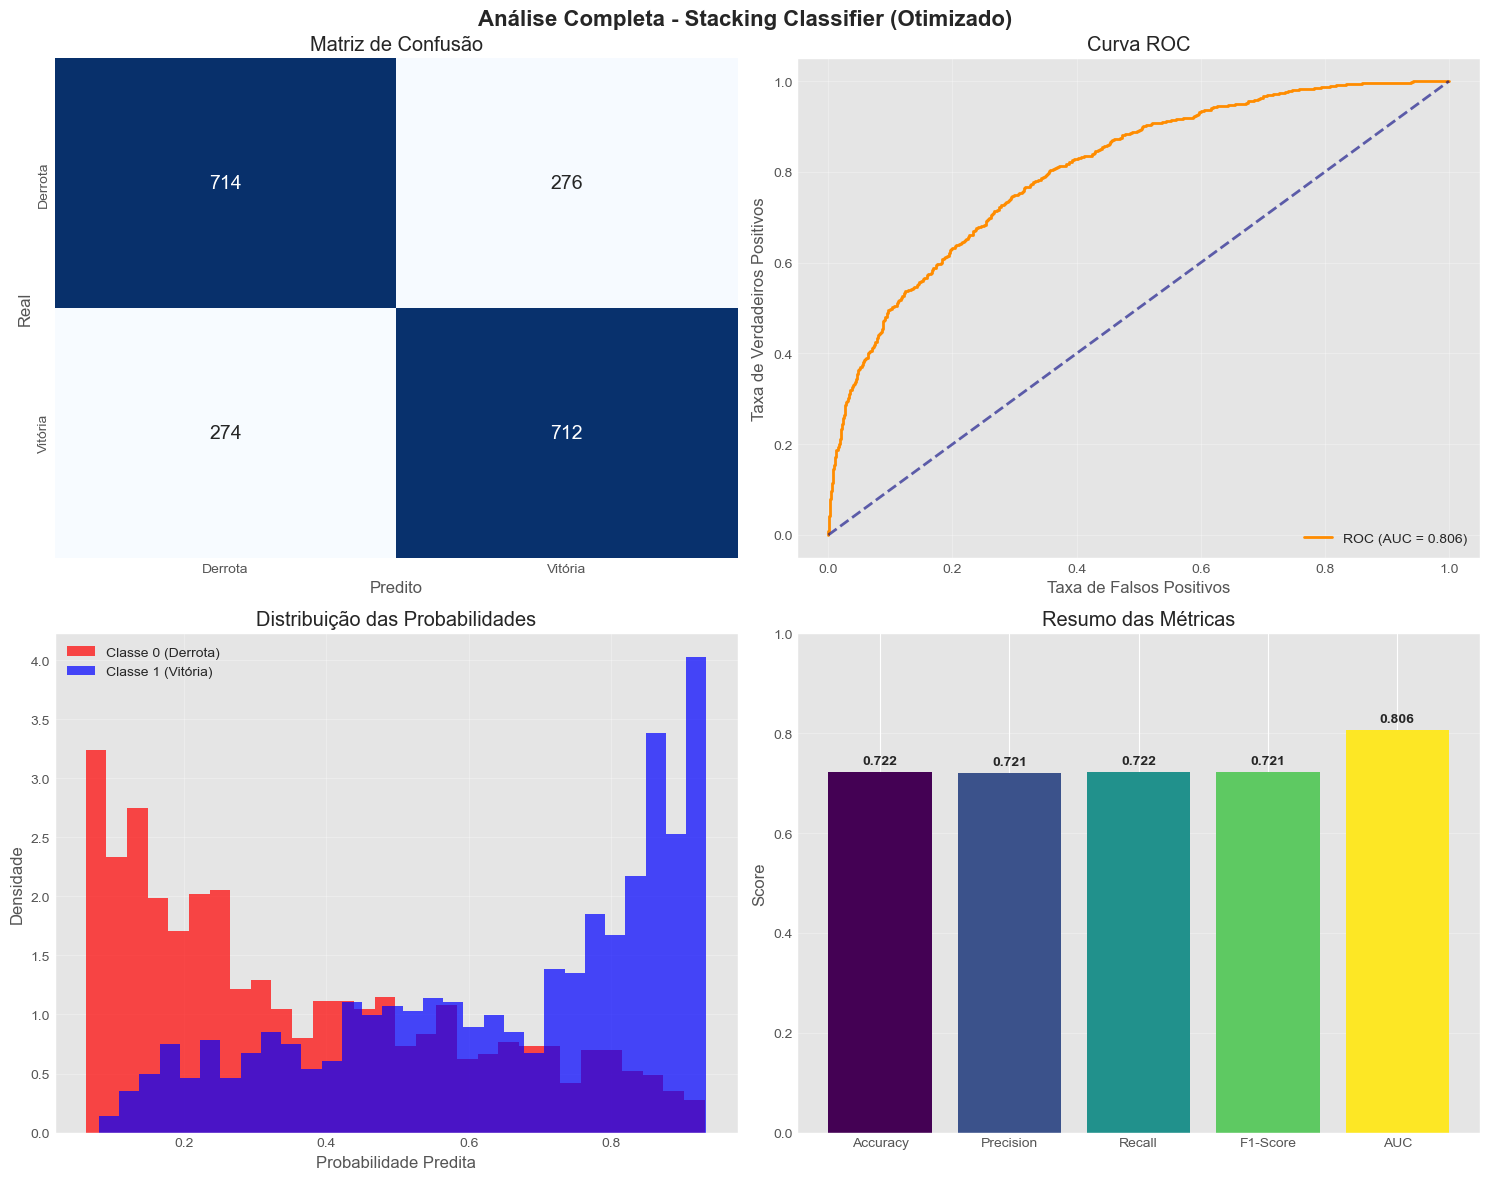


Relatório de Classificação Detalhado:
              precision    recall  f1-score   support

     Derrota       0.72      0.72      0.72       990
     Vitória       0.72      0.72      0.72       986

    accuracy                           0.72      1976
   macro avg       0.72      0.72      0.72      1976
weighted avg       0.72      0.72      0.72      1976


Stacking Classifier (Otimizado) avaliado com sucesso!

COMPARAÇÃO DOS MODELOS
                         Modelo           CV_AUC Test_AUC Test_Accuracy Test_F1 Test_Precision Test_Recall
            Regressão Logística 0.8121 (±0.0084)   0.8060        0.7201  0.7217         0.7163      0.7272
                    Naive Bayes 0.8035 (±0.0080)   0.7993        0.7171  0.7149         0.7190      0.7110
              Árvore de Decisão 0.8010 (±0.0074)   0.7937        0.7186  0.7119         0.7278      0.6968
                  Random Forest 0.7994 (±0.0068)   0.7964        0.7151  0.7123         0.7178      0.7069
  Voting Classifier 

In [61]:
# Avaliar modelos de ensemble otimizados
resultados_ensemble_otimizados = run_complete_evaluation(optimized_ensemble_models, X_train_balanced, y_train_balanced, X_test_scaled, y_test)

## AVALIAÇÃO FINAL

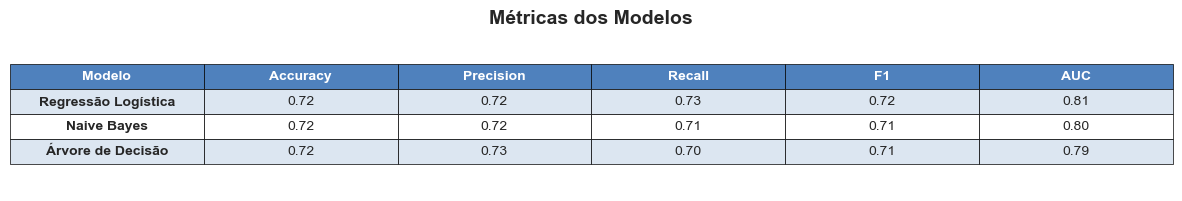

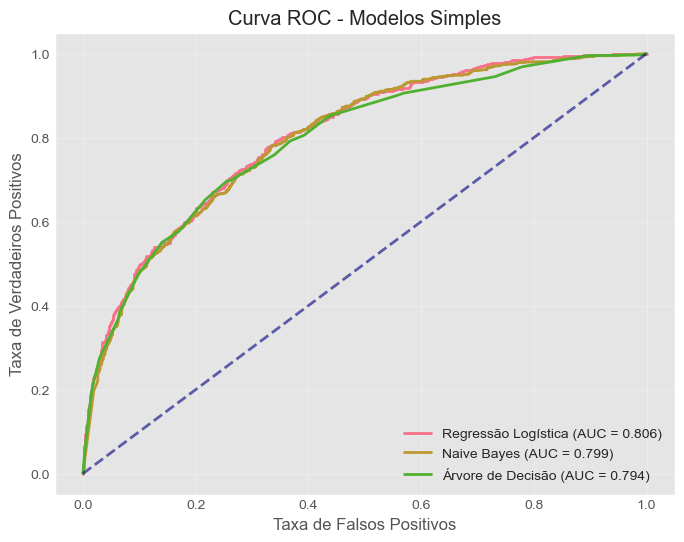

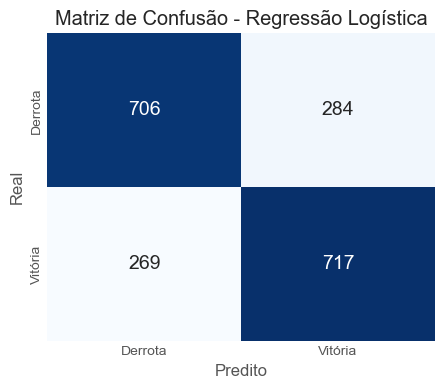

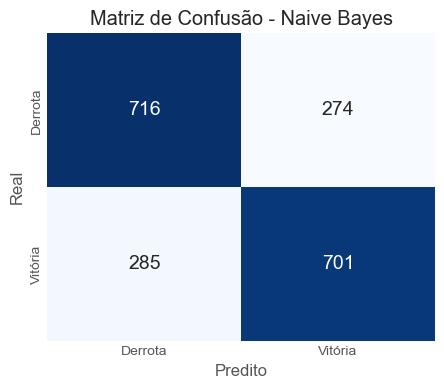

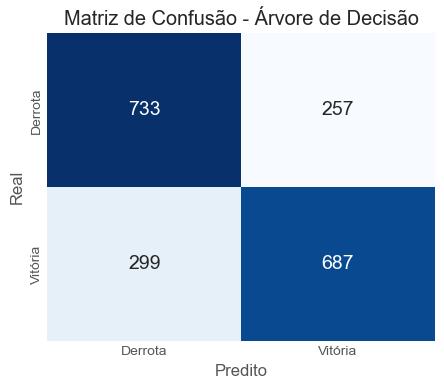

In [62]:
# Modelos simples
simple_models = ['Regressão Logística', 'Naive Bayes', 'Árvore de Decisão']

# ===========================
# 1. Tabela de métricas
# ===========================
metrics_summary = []
for model_name in simple_models:
    res = all_results[model_name]
    metrics_summary.append([
        model_name,
        f"{res['Test_Accuracy']:.2f}",
        f"{res['Test_Precision']:.2f}",
        f"{res['Test_Recall']:.2f}",
        f"{res['Test_F1']:.2f}",
        f"{res['Test_AUC']:.2f}"
    ])

# Configurações de cores
header_color = "#4F81BD"
row_colors = ["#DCE6F1", "#FFFFFF"]  # alterna linhas azul claro / branco
edge_color = "black"

# Preparar lista de cores para cada linha
cell_colors = []
for i in range(len(metrics_summary)):
    # Cada linha precisa ter 6 cores, uma para cada coluna
    cell_colors.append([row_colors[i % 2]] * 6)

# Criar figura da tabela
fig, ax = plt.subplots(figsize=(10, 2))
ax.axis('off')

# Criar tabela
table = ax.table(cellText=metrics_summary,
                 colLabels=['Modelo','Accuracy','Precision','Recall','F1','AUC'],
                 cellLoc='center',
                 loc='center',
                 colColours=[header_color]*6,
                 cellColours=cell_colors)

# Ajuste de fonte e escala
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.5, 1.5)

# Bordas e estilo
for key, cell in table.get_celld().items():
    cell.set_edgecolor(edge_color)
    if key[0] == 0:  # cabeçalho
        cell.set_text_props(weight='bold', color='white')
    else:
        if key[1] == 0:  # nome do modelo
            cell.set_text_props(weight='bold')

plt.title("Métricas dos Modelos", fontsize=14, fontweight='bold', pad=10)
plt.show()


# ===========================
# 2. Curva ROC
# ===========================
plt.figure(figsize=(8,6))
for model_name in simple_models:
    res = all_results[model_name]
    y_pred_proba = res['y_pred_proba']
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    auc_score = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{model_name} (AUC = {auc_score:.3f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', alpha=0.6)
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC - Modelos Simples')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

# ===========================
# 3. Matriz de Confusão
# ===========================
for model_name in simple_models:
    res = all_results[model_name]
    y_pred = (res['y_pred_proba'] >= 0.5).astype(int)
    fig, ax1 = plt.subplots(figsize=(5,4))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax1,
                annot_kws={'size': 14})
    ax1.set_title(f'Matriz de Confusão - {model_name}')
    ax1.set_xlabel('Predito')
    ax1.set_ylabel('Real')
    ax1.set_xticklabels(['Derrota', 'Vitória'])
    ax1.set_yticklabels(['Derrota', 'Vitória'])
    plt.show()